In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.integrate import solve_ivp
import seaborn as sns

# Core functions
These functions are used for the core calculations needed to visualise the data

### All rate equations defined here

In [2]:
"""Irreversible Henri-Michaelis Menten kinetics"""
def Irr_Michaelis_Menten (S, Vmax, Km):
    return(Vmax*S / (Km+S))

"""Irreversible specific activation kinetics"""
def Irr_Spec_Action (S, A, Vmax, Km, ka):
    return(Vmax*S*A / (Km*ka + (Km+S) * A))

"""Irreversible non-competitive inhibition"""
def Irr_Noncomp_Inhib (S, I, Vmax, Km, ki):
    return(Vmax*S / ((Km+S)*(1+I/ki) + S))

"""Irreversible competitive inhibition"""
def Irr_Comp_Inhib (S, I, Vmax, Km, ki):
    return(Vmax*S / (Km*(1+I/ki) + S))

"""Reversible Bi-bi kinetics"""
def Rev_BiBi (S, ATP, aps, ppi, Vf, Km_S, Km_ATP, Km_aps, Km_ppi, keq):
    return(Vf/Km_S/Km_ATP * (S*ATP - (aps*ppi/keq)) / (1 + S/Km_S + ATP/Km_ATP + S*ATP/Km_S/Km_ATP + aps/Km_aps + ppi/Km_ppi + aps*ppi/Km_aps/Km_ppi))

"""Mass action kinetics
Used for consumption of molecules"""
def Consume (S, k):
    return(k*S)

"""Constant flux 
Used for production of molecules"""
def Produce (v):
    return(v)

"""Reversible Henri-Michaelis-Menten kinetics """
def Rev_Michaelis_Menten (S, P, Vf, Vr, Km_S, Km_P):
    return((Vf*S/Km_S - Vr*P/Km_P) / (1+S/Km_S+P/Km_P))

"""Reversible Ter kinetics for APRp"""
def APRp (aps, GSH, SO3, GSSG, AMP, Vmax, Km_aps, Km_GSH, Km_SO3, Km_GSSG, Km_AMP, keq):
    return (Vmax/Km_aps/Km_GSH**2 * (aps*GSH**2 - SO3*GSSG*AMP/keq) / ( (1+aps/Km_aps)*(1+GSH/Km_GSH)**2 + (1+SO3/Km_SO3)*(1+GSSG/Km_GSSG)*(1+AMP/Km_AMP) -1 ))

"""Reversible Henri-Michaelis-Menten kinetics for SiR"""
def SiR (S, P, Vmax, Km_S, Km_P, keq):
    return(Vmax/Km_S * (S-P/keq) / (1+S/Km_S+P/Km_P))

"""Ordered Bi-Bi, substrate inhibition"""
def Ord_Bi_Bi_Sub_Inhib (A, B, P, Q, Vmax, Km_a, Km_b, Km_p, Km_q, ki_a, KI_B, ki_p, ki_q, K__IB, k__iq):
    return(Vmax*A*B / ( ki_a*Km_b + Km_b*A + Km_a*B + A*B + A*B**2/KI_B + Km_b*ki_a*Km_q*P/ki_q/Km_p + Km_b*A*P/ki_p + Km_b*Km_q*A*P/ki_q/Km_p + A*B*P/ki_p + Km_b*Km_q*A*P**2/ki_q/Km_p/ki_p + Km_b*ki_a*Q/ki_q + Km_a*B*Q/k__iq + ki_a*B**2*Q/ki_q*K__IB) )


### The simulation function is defined here 
`time` is a used by the _solve_ivp_ solver and is a tuple of (start_time, end_time). <br>
`starting_states` is an ndarray with the starting concentrations of the simulation. <br>
`parameters` is and ndarray with the kinetic parameters of the rate equations (plus fixed concentrations of certain metabolites) <br>
`adjust` is an ndarray that contains a modifier to the rate of adjust[i] equation, used for flux analysis.


In [3]:
def Kinetics (time, starting_states, parameters, adjust):

    #Compartment volumes in litres 
    V_c = 5.4e-8 
    V_p = 2.54e-7
    V_v = 6.8e-7 

    #Defining the initial states
    (SO4ic, SO4iv, SO4ip, APSc, PPic, APSp, PPip,
    SO3p, Sp, PAPSc, PAPSp, ADPc, ADPp, AMPp) = starting_states

    #Defining the parameters
    (Vm_Sultr1_1, Km_Sultr1_1, 
     Vm_Sultr1_2, Km_Sultr1_2, 
     Vm_Sultr4cv, Km_Sultr4cv, ka_Sultr4cv, 
     Vm_Sultr4vc, Km_Sultr4vc, ki_Sultr4vc, 
     Vf_ATPSc, KmS_ATPSc, Kmatp_ATPSc, Kmaps_ATPSc, Kmppi_ATPSc, keq_ATPSc, 
     k_APSc, k_PPic,
     Vf_Sultr3cp, Vr_Sultr3cp, KmS_Sultr3cp, KmP_Sultr3cp,
     Vf_ATPSp, KmS_ATPSp, Kmatp_ATPSp, Kmaps_ATPSp, Kmppi_ATPSp, keq_ATPSp,
     k_APSp, k_PPip,
     Vm_APRp, Kmaps_APRp, Kmgsh_APRp, KmSO3_APRp, Kmgssg_APRp, Kmamp_APRp, keq_APRp,
     k_SO3p, 
     Vm_SiR, KmS_SiR, KmP_SiR, keq_SiR,
     ATP_c, ATP_p, SO4_ex, GSHp, GSSGp, 
     Vm_APK_c, Km_a_APK_c, Km_b_APK_c, Km_p_APK_c, Km_q_APK_c, ki_a_APK_c, KI_B_APK_c, ki_p_APK_c, ki_q_APK_c, K__IB_APK_c, k__iq_APK_c,
     Vm_APK_p, Km_a_APK_p, Km_b_APK_p, Km_p_APK_p, Km_q_APK_p, ki_a_APK_p, KI_B_APK_p, ki_p_APK_p, ki_q_APK_p, K__IB_APK_p, k__iq_APK_p,
     k_ADPc, k_ADPp, k_AMPp, 
     Vm_PAPST1, Km_PAPST1, ki_PAPST1, 
     k_PAPSc, k_Sp) = parameters
    

    #Rate equations stored in:
    dydt = np.empty(len(starting_states))

    #Change of SO4ic. 6 reactions: +Sultr1;1, +Sultr1;2, -Sultr3cp, -Sultr4cv, +Sultr4vc, -ATPSc
    dydt[0] = ( 
                + Irr_Michaelis_Menten(SO4_ex, Vm_Sultr1_1, Km_Sultr1_1) / V_c * adjust[0]
                + Irr_Michaelis_Menten(SO4_ex, Vm_Sultr1_2, Km_Sultr1_2) / V_c * adjust[1]
                - Rev_Michaelis_Menten(SO4ic, SO4ip, Vf_Sultr3cp, Vr_Sultr3cp, KmS_Sultr3cp, KmP_Sultr3cp) / V_c * adjust[2]
                - Irr_Spec_Action(SO4ic, SO4ic, Vm_Sultr4cv, Km_Sultr4cv, ka_Sultr4cv)/ V_c * adjust[3]
                + Irr_Noncomp_Inhib(SO4iv, SO4ic, Vm_Sultr4vc, Km_Sultr4vc, ki_Sultr4vc)/ V_c * adjust[4]
                - Rev_BiBi(SO4ic, ATP_c, APSc, PPic, Vf_ATPSc, KmS_ATPSc, Kmatp_ATPSc, Kmaps_ATPSc, Kmppi_ATPSc, keq_ATPSc) * adjust[5]
    )

    #Change of SO4iv.  2 reactions: +Sultr4cv,  -Sultr4vc,
    dydt[1] = ( 
                + Irr_Spec_Action(SO4ic, SO4ic, Vm_Sultr4cv, Km_Sultr4cv, ka_Sultr4cv) / V_v *adjust[3]
                - Irr_Noncomp_Inhib(SO4iv, SO4ic, Vm_Sultr4vc, Km_Sultr4vc, ki_Sultr4vc) / V_v *adjust[4]
    )
    
    #Change of SO4ip. 2 reactions: -ATPSp, +Sultr3cp
    dydt[2] = (
                - Rev_BiBi(SO4ip, ATP_p, APSp, PPip, Vf_ATPSp, KmS_ATPSp, Kmatp_ATPSp, Kmaps_ATPSp, Kmppi_ATPSp, keq_ATPSp) * adjust[6]
                + Rev_Michaelis_Menten(SO4ic, SO4ip, Vf_Sultr3cp, Vr_Sultr3cp, KmS_Sultr3cp, KmP_Sultr3cp) / V_p * adjust[2]
    )

    #Change of APSc. 2 Reactions: +ATPSc, -APK
    dydt[3] = (
                + Rev_BiBi(SO4ic, ATP_c, APSc, PPic, Vf_ATPSc, KmS_ATPSc, Kmatp_ATPSc, Kmaps_ATPSc, Kmppi_ATPSc, keq_ATPSc) * adjust[5]
                - Ord_Bi_Bi_Sub_Inhib(ATP_c, APSc, PAPSc, ADPc, Vm_APK_c, Km_a_APK_c, Km_b_APK_c, Km_p_APK_c, Km_q_APK_c, ki_a_APK_c, KI_B_APK_c, ki_p_APK_c, ki_q_APK_c, K__IB_APK_c, k__iq_APK_c) * adjust[7]
    )
    
    #Change of PPic. 2 reactions: +ATPSc, -kPPic
    dydt[4] = (
                + Rev_BiBi(SO4ic, ATP_c, APSc, PPic, Vf_ATPSc, KmS_ATPSc, Kmatp_ATPSc, Kmaps_ATPSc, Kmppi_ATPSc, keq_ATPSc) * adjust[5]
                - Consume(PPic, k_PPic) *adjust[18]
    )
    
    #Change of APSp. 3 reactions: +ATPSp, -APRp, -APK. 
    dydt[5] = (
                 + Rev_BiBi(SO4ip, ATP_p, APSp, PPip, Vf_ATPSp, KmS_ATPSp, Kmatp_ATPSp, Kmaps_ATPSp, Kmppi_ATPSp, keq_ATPSp) * adjust[6]
                 - APRp(APSp, GSHp, SO3p, GSSGp, AMPp, Vm_APRp, Kmaps_APRp, Kmgsh_APRp, KmSO3_APRp, Kmgssg_APRp, Kmamp_APRp, keq_APRp) * adjust[10]
                 - Ord_Bi_Bi_Sub_Inhib(ATP_p, APSp, PAPSp, ADPp, Vm_APK_p, Km_a_APK_p, Km_b_APK_p, Km_p_APK_p, Km_q_APK_p, ki_a_APK_p, KI_B_APK_p, ki_p_APK_p, ki_q_APK_p, K__IB_APK_p, k__iq_APK_p) * adjust[8]
    )
    
    #Change of PPip. 2 reactions: +ATPSp, -kPPip
    dydt[6] = (
                 + Rev_BiBi(SO4ip, ATP_p, APSp, PPip, Vf_ATPSp, KmS_ATPSp, Kmatp_ATPSp, Kmaps_ATPSp, Kmppi_ATPSp, keq_ATPSp) * adjust[6]
                 - Consume(PPip, k_PPip) * adjust[19]
    )

    #Change of SO3p. 3 reactions: +APRp, -SiRp, -kSO3
    dydt[7] = (
                + APRp(APSp, GSHp, SO3p, GSSGp, AMPp, Vm_APRp, Kmaps_APRp, Kmgsh_APRp, KmSO3_APRp, Kmgssg_APRp, Kmamp_APRp, keq_APRp) * adjust[10]
                - SiR(SO3p, Sp, Vm_SiR, KmS_SiR, KmP_SiR, keq_SiR) * adjust[11]
                - Consume(SO3p, k_SO3p) * adjust[13]
    )

    #Change of Sp 
    dydt[8] = (
                + SiR(SO3p, Sp, Vm_SiR, KmS_SiR, KmP_SiR, keq_SiR) * adjust[11]
                - Consume(Sp, k_Sp) * adjust[14]
    )

    #Change of PAPSc
    dydt[9] = (
                + Ord_Bi_Bi_Sub_Inhib(ATP_c, APSc, PAPSc, ADPc, Vm_APK_c, Km_a_APK_c, Km_b_APK_c, Km_p_APK_c, Km_q_APK_c, ki_a_APK_c, KI_B_APK_c, ki_p_APK_c, ki_q_APK_c, K__IB_APK_c, k__iq_APK_c) * adjust[7]
                + Irr_Comp_Inhib(PAPSp, ATP_p, Vm_PAPST1, Km_PAPST1, ki_PAPST1) / V_c *adjust[9]
                - Consume(PAPSc, k_PAPSc) * adjust[12]
    )

    #Change of PAPSp
    dydt[10] = (
                + Ord_Bi_Bi_Sub_Inhib(ATP_p, APSp, PAPSp, ADPp, Vm_APK_p, Km_a_APK_p, Km_b_APK_p, Km_p_APK_p, Km_q_APK_p, ki_a_APK_p, KI_B_APK_p, ki_p_APK_p, ki_q_APK_p, K__IB_APK_p, k__iq_APK_p) * adjust[8]           
                - Irr_Comp_Inhib(PAPSp, ATP_p, Vm_PAPST1, Km_PAPST1, ki_PAPST1) / V_p * adjust[9]
    )
    #Change of ADPc
    dydt[11] = (
                + Ord_Bi_Bi_Sub_Inhib(ATP_c, APSc, PAPSc, ADPc, Vm_APK_c, Km_a_APK_c, Km_b_APK_c, Km_p_APK_c, Km_q_APK_c, ki_a_APK_c, KI_B_APK_c, ki_p_APK_c, ki_q_APK_c, K__IB_APK_c, k__iq_APK_c) * adjust[7]
                - Consume(ADPc, k_ADPc) * adjust[15]
    )
    
    #Change of ADPp
    dydt[12] = (
                + Ord_Bi_Bi_Sub_Inhib(ATP_p, APSp, PAPSp, ADPp, Vm_APK_p, Km_a_APK_p, Km_b_APK_p, Km_p_APK_p, Km_q_APK_p, ki_a_APK_p, KI_B_APK_p, ki_p_APK_p, ki_q_APK_p, K__IB_APK_p, k__iq_APK_p) * adjust[8]
                - Consume(ADPp, k_ADPp) * adjust[16]                
    )
    #Change of AMPp
    dydt[13] = (
                + APRp(APSp, GSHp, SO3p, GSSGp, AMPp, Vm_APRp, Kmaps_APRp, Kmgsh_APRp, KmSO3_APRp, Kmgssg_APRp, Kmamp_APRp, keq_APRp) * adjust[10]
                - Consume(AMPp, k_AMPp) * adjust[17]
    )
    
    return dydt

### Flux calculations
The function below is used to calculate the steady-state fluxes of each reaction within the pathway.

In [4]:
"""Gives fluxes of each reaction at steady state"""
def Flux_test (starting_states, parameters, adjust):
    fluxes = np.empty(len(adjust))
    
    #Compartment volumes in litres 
    V_c = 5.4e-8 
    V_p = 2.54e-7
    V_v = 6.8e-7 
    
    #Defining the initial states
    (SO4ic, SO4iv, SO4ip, APSc, PPic, APSp, PPip,
    SO3p, Sp, PAPSc, PAPSp, ADPc, ADPp, AMPp) = starting_states

    #Defining the parameters
    (Vm_Sultr1_1, Km_Sultr1_1, 
     Vm_Sultr1_2, Km_Sultr1_2, 
     Vm_Sultr4cv, Km_Sultr4cv, ka_Sultr4cv, 
     Vm_Sultr4vc, Km_Sultr4vc, ki_Sultr4vc, 
     Vf_ATPSc, KmS_ATPSc, Kmatp_ATPSc, Kmaps_ATPSc, Kmppi_ATPSc, keq_ATPSc, 
     k_APSc, k_PPic,
     Vf_Sultr3cp, Vr_Sultr3cp, KmS_Sultr3cp, KmP_Sultr3cp,
     Vf_ATPSp, KmS_ATPSp, Kmatp_ATPSp, Kmaps_ATPSp, Kmppi_ATPSp, keq_ATPSp,
     k_APSp, k_PPip,
     Vm_APRp, Kmaps_APRp, Kmgsh_APRp, KmSO3_APRp, Kmgssg_APRp, Kmamp_APRp, keq_APRp,
     k_SO3p, 
     Vm_SiR, KmS_SiR, KmP_SiR, keq_SiR,
     ATP_c, ATP_p, SO4_ex, GSHp, GSSGp, 
     Vm_APK_c, Km_a_APK_c, Km_b_APK_c, Km_p_APK_c, Km_q_APK_c, ki_a_APK_c, KI_B_APK_c, ki_p_APK_c, ki_q_APK_c, K__IB_APK_c, k__iq_APK_c,
     Vm_APK_p, Km_a_APK_p, Km_b_APK_p, Km_p_APK_p, Km_q_APK_p, ki_a_APK_p, KI_B_APK_p, ki_p_APK_p, ki_q_APK_p, K__IB_APK_p, k__iq_APK_p,
     k_ADPc, k_ADPp, k_AMPp, 
     Vm_PAPST1, Km_PAPST1, ki_PAPST1, 
     k_PAPSc, k_Sp) = parameters
    
    #Sultr1_1
    fluxes[0] = Irr_Michaelis_Menten(SO4_ex, Vm_Sultr1_1, Km_Sultr1_1) / V_c * adjust[0]
    
    #Sultr1_2
    fluxes[1] = Irr_Michaelis_Menten(SO4_ex, Vm_Sultr1_2, Km_Sultr1_2) / V_c * adjust[1]
    
    #Sultr3cp
    fluxes[2] = Rev_Michaelis_Menten(SO4ic, SO4ip, Vf_Sultr3cp, Vr_Sultr3cp, KmS_Sultr3cp, KmP_Sultr3cp) / V_c * adjust[2]
    
    #Sultr4cv
    fluxes[3] = Irr_Spec_Action(SO4ic, SO4ic, Vm_Sultr4cv, Km_Sultr4cv, ka_Sultr4cv)/ V_c * adjust[3]
    
    #Sultr4vc
    fluxes[4] = Irr_Noncomp_Inhib(SO4iv, SO4ic, Vm_Sultr4vc, Km_Sultr4vc, ki_Sultr4vc)/ V_c * adjust[4]
    
    #ATPSc
    fluxes[5] = Rev_BiBi(SO4ic, ATP_c, APSc, PPic, Vf_ATPSc, KmS_ATPSc, Kmatp_ATPSc, Kmaps_ATPSc, Kmppi_ATPSc, keq_ATPSc) * adjust[5]
    
    #ATPSp
    fluxes[6] = Rev_BiBi(SO4ip, ATP_p, APSp, PPip, Vf_ATPSp, KmS_ATPSp, Kmatp_ATPSp, Kmaps_ATPSp, Kmppi_ATPSp, keq_ATPSp) * adjust[6]
    
    #APKc
    fluxes[7] = Ord_Bi_Bi_Sub_Inhib(ATP_c, APSc, PAPSc, ADPc, Vm_APK_c, Km_a_APK_c, Km_b_APK_c, Km_p_APK_c, Km_q_APK_c, ki_a_APK_c, KI_B_APK_c, ki_p_APK_c, ki_q_APK_c, K__IB_APK_c, k__iq_APK_c) * adjust[7]
    
    #APKp
    fluxes[8] = Ord_Bi_Bi_Sub_Inhib(ATP_p, APSp, PAPSp, ADPp, Vm_APK_p, Km_a_APK_p, Km_b_APK_p, Km_p_APK_p, Km_q_APK_p, ki_a_APK_p, KI_B_APK_p, ki_p_APK_p, ki_q_APK_p, K__IB_APK_p, k__iq_APK_p) * adjust[8]
    
    #PAPST1
    fluxes[9] = Irr_Comp_Inhib(PAPSp, ATP_p, Vm_PAPST1, Km_PAPST1, ki_PAPST1) / V_c *adjust[9]
    
    #APRp
    fluxes[10] = APRp(APSp, GSHp, SO3p, GSSGp, AMPp, Vm_APRp, Kmaps_APRp, Kmgsh_APRp, KmSO3_APRp, Kmgssg_APRp, Kmamp_APRp, keq_APRp) * adjust[10]
    
    #SiRp
    fluxes[11] = SiR(SO3p, Sp, Vm_SiR, KmS_SiR, KmP_SiR, keq_SiR) * adjust[11]
    
    #k_PAPSc 
    fluxes[12] = Consume(PAPSc, k_PAPSc) * adjust[12]
    
    #k_SO3p
    fluxes[13] = Consume(SO3p, k_SO3p) * adjust[13]
    
    #k_Sp
    fluxes[14] = Consume(Sp, k_Sp) * adjust[14]
    
    #k_ADPc
    fluxes[15] = Consume(ADPc, k_ADPc) * adjust[15]
    
    #k_ADPp
    fluxes[16] = Consume(ADPp, k_ADPp) * adjust[16]         
    
    #k_AMPp
    fluxes[17] = Consume(AMPp, k_AMPp) * adjust[17]
    
    #k_PPic
    fluxes[18] = Consume(PPic, k_PPic) *adjust[18]
    
    #PPip
    fluxes[19] = Consume(PPip, k_PPip) * adjust[19]
    
    return fluxes
    

## Model analysis.
The functions below are used for the starvation analysis and MCA.

### 'Controls'
The functions are used to generate the 'control' outputs. Essentially, these are used to quantify relative changes in steady-state concentrations or flux. 

In [5]:
"""Calculate the steady-states of the model ensemble"""
def Generate_output (time, Starting_states, params, Adjust):
    Actual_outputs = np.empty((50,14))
    for i in range(50):
        Act_output = solve_ivp(Kinetics, time, Starting_states, method='LSODA', atol=1e-6, rtol=1e-12, args=(params[i], Adjust))
        out_y = Act_output['y']
        Actual_outputs[i] = out_y[:,-1]
    return(Actual_outputs)

"""Calculates the steady-state outputs for model ensemble under specified starvation conditions
starve is an ndarray of specific concentrations, who is a string: either 'SO4' or 'ATP' - determines which concentration is modified"""
def Starve_true_outputs(time, Starting_states, params, Adjust, starve, who):
    Starve_true_outputs = np.empty((len(starve), 50, 14))
    for i in range(len(starve)):
        for j in range(50):
            params=np.array(All_params[j])
            if who =='SO4':
                params[44] = starve[i]
            if who =='ATP':
                params[42] = starve[i]
                params[43] = starve[i]
            sim_starve = solve_ivp(Kinetics, time, Starting_states, method='LSODA', atol=1e-6, rtol=1e-12, args=(params, Adjust))
            sim_starve_y = sim_starve['y']
            Starve_true_outputs[i,j] = sim_starve_y[:,-1]
    return Starve_true_outputs

"""Calculate the steady-state outputs when individual velocities are adjusted"""
def True_flux(time, Starting_states, params, Adjust):
    Flux_Outputs = np.empty((20,50,14))
    for i in range(50):
        for k in range(len(Adjust)):
            Adjust[k] = 1.2
            Flux_output = solve_ivp(Kinetics, time, Starting_states, method='LSODA', atol=1e-6, rtol=1e-12, args=(params[i], Adjust))
            Flux_y = Flux_output['y']
            Flux_Outputs[k,i] = Flux_y[:,-1]
            Adjust[k] = 1        
    return(Flux_Outputs)

### Starvation analysis.
These functions calculate the steady-state response within a defined concentration range which is given as the ndarray `starve`

In [6]:
"""Calculate the steady-state response for SO4 starvation within a range"""
def SO4_starve_analayze(time, Starting_states, params, Adjust, starve):
    SO4_adjust_Outputs = np.empty((50, 50, 14))
    for i in range(50):
        for j in range(len(starve)):
            params[i, 44] = starve[j]
            SO4_adjust = solve_ivp(Kinetics, time, Starting_states, method='LSODA', atol=1e-6, rtol=1e-12, args=(params[i], Adjust))
            Adjust_y = SO4_adjust['y']
            SO4_adjust_Outputs[j,i] = Adjust_y[:,-1]
    return(SO4_adjust_Outputs)

"""Calculates the steady-state response for ATP starvation within a range"""
def ATP_starve_analyze(time, Starting_states, params, Adjust, starve):
    ATP_adjust_Outputs = np.empty((50, 50, 14))
    for i in range(50):
        for j in range(len(starve)):
            params[i, 42] = starve[j]
            params[i, 43] = starve[j]
            ATP_adjust = solve_ivp(Kinetics, time, Starting_states, method='LSODA', atol=1e-6, rtol=1e-12, args=(params[i], Adjust))
            Adjust_y = ATP_adjust['y']
            ATP_adjust_Outputs[j,i] = Adjust_y[:,-1]
    return(ATP_adjust_Outputs)

### MCA
The functions below are used for calculations in the MCA.

In [7]:
"""Calculates the steady-state outputs for model ensemble under starvation and adjusted flux of reactions"""
def Starve_flux(time, Starting_states, params, Adjust, starve, who):
    Starve_outputs = np.empty((len(starve), len(Adjust), 50, 14))
    for i in range(len(starve)):
        for j in range(50):
            params=np.array(All_params[j])
            if who =='SO4':
                params[44] = starve[i]
            if who =='ATP':
                params[42] = starve[i]
                params[43] = starve[i]
                
            for k in range(len(Adjust)):
                Adjust[k]=1.2
                sim_flux_starve = solve_ivp(Kinetics, time, Starting_states, method='LSODA', atol=1e-6, rtol=1e-12, args=(params, Adjust))
                sim_flux_y=sim_flux_starve['y']
                Starve_outputs[i,k,j] = sim_flux_y[:,-1]
                Adjust[k]=1
                
    return Starve_outputs

"""Calculates the fluxes for the ensemble under specified starvation conditions"""
def Calculate_flux_starve(true_starve_output, flux_starve_output, params, Adjust, starve, who):
    starve_flux_reaction = np.empty((len(Adjust), 50, 20))
    starve_actual_reaction = np.empty((50, 20))
    for i in range(50):
        params = np.array(All_params[i])
        if who == 'SO4':
            params[44] = starve
        if who == 'ATP':
            params[42] = starve
            params[43] = starve
        starve_actual_reaction[i] = Flux_test(true_starve_output[i], params, Adjust)
        for j in range(len(Adjust)):
            Adjust[j] = 1.2
            starve_flux_reaction[j,i] = Flux_test(flux_starve_output[j,i], params, Adjust)
            Adjust[j] = 1.0
    return starve_actual_reaction, starve_flux_reaction

## Load all the files needed and set variables

In [8]:
Ordered_states_DF = pd.read_csv('States_order.csv')
Ordered_params_DF = pd.read_csv('Ordered_params.csv')
Model_states_DF = pd.read_csv('Model states.csv')
Parameter_bound_DF = pd.read_csv('Parameter bounds.csv')
Steady_states_DF=pd.read_csv('Steady_simple.csv')
All_reactions_DF=pd.read_csv('All reactions.csv')

#Rearranging the starting states for easier readability
Ordered_states = np.array(Ordered_states_DF['Names'])
Model_states_names = np.array(Model_states_DF['Name'])
Model_states_values = np.array(Model_states_DF['Simple']) #keep in mind this can be changed to test different starting state sets
Model_States_Dict = dict(zip(Model_states_names, Model_states_values))

Starting_states = np.empty(len(Ordered_states))
for i in range(len(Ordered_states)):
    Starting_states[i] = Model_States_Dict[Ordered_states[i]]

Ordered_params = np.array(Ordered_params_DF['Name'])
Adjust = np.array(All_reactions_DF['change_5'], dtype=float)

Ordered_reactions = np.array(All_reactions_DF['Reaction'])

time = (0, 1e6)

"""Loading the parameters from the txt files"""
All_params = np.empty((50, 77))
for i in range(50):
    All_params[i] = np.loadtxt('Output_fit_new{}.txt'.format(i+1))

ATP_adjust_concentration = np.linspace(0.01, 2000, 50)
SO4_adjust_concentration = np.linspace(0.01, 1600, 50)

SO4_starve = np.array([1, 50, 100])
ATP_starve = np.array([1, 50, 100, 250])

**To save time, you can use the npy files included instead of running the calculations**

In [9]:
True_output = np.load('Output.npy')
ATP_output = np.load('ATP_Output.npy')
Flux_output = np.load('Flux_Output.npy')
SO4_output = np.load('SO4_Output.npy')
SO4_starve_output_true = np.load('SO4_starve_output_true.npy')
SO4_starve_flux_outputs = np.load('SO4_starve_flux_outputs_n.npy')
ATP_starve_output_true = np.load('ATP_starve_output_true.npy')
ATP_starve_flux_outputs = np.load('ATP_starve_flux_outputs_n.npy')
SO4_starve_Actual_reactions = np.load('SO4_starve_Actual_reactions.npy')
SO4_starve_Flux_reactions = np.load('SO4_starve_Flux_reactions.npy')
ATP_starve_Actual_reactions = np.load('ATP_starve_Actual_reactions.npy')
ATP_starve_Flux_reactions = np.load('ATP_starve_Flux_reactions.npy')

**Otherwise run the cell below to calculate everything from scratch**

In [10]:
#True_output = Generate_output(time, Starting_states, All_params, Adjust)
#ATP_output = ATP_starve_analyze(time, Starting_states, All_params, Adjust, ATP_adjust_concentration)
#SO4_output = SO4_starve_analayze(time, Starting_states, All_params, Adjust, SO4_adjust_concentration)
#Flux_output = True_flux(time, Starting_states, All_params, Adjust)
#Calculates the outputs during starvation on original ensemble and with updated velocities
#SO4_starve_output_true = Starve_true_outputs(time, Starting_states, All_params, Adjust, SO4_starve, 'SO4')
#ATP_starve_output_true = Starve_true_outputs(time, Starting_states, All_params, Adjust, ATP_starve, 'ATP')
#SO4_starve_flux_outputs = Starve_flux(time, Starting_states, All_params, Adjust, SO4_starve, 'SO4') 
#ATP_starve_flux_outputs = Starve_flux(time, Starting_states, All_params, Adjust, ATP_starve, 'ATP')
#Calculates fluxes for original ensemble under starvation and with update velocities
#SO4_starve_Actual_reactions, SO4_starve_Flux_reactions = Calculate_flux_starve(SO4_starve_output_true[0], SO4_starve_flux_outputs[0], All_params, Adjust,  SO4_starve[0], 'SO4')
#ATP_starve_Actual_reactions, ATP_starve_Flux_reactions = Calculate_flux_starve(ATP_starve_output_true[0], ATP_starve_flux_outputs[0], All_params, Adjust,  ATP_starve[0], 'ATP')

# Here all the visualisation of the data is coded

## Starvation analysis

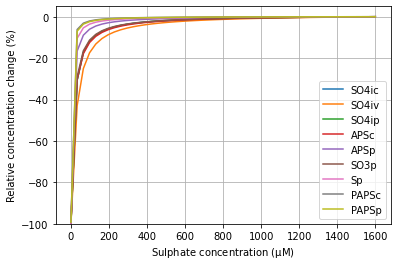

In [11]:
"""Visualise the response to sulphate starvation"""
so4_change = ((SO4_output/True_output)-1)*100
so4_mean = np.mean(so4_change, 1)
exclude = np.array([4,6,11,12,13])
for i in range (len(so4_mean[0])):
    if not np.any(np.equal(exclude, i)):
        plt.plot(SO4_adjust_concentration, so4_mean[:,i], label=Ordered_states[i])
        plt.legend()
plt.ylabel('Relative concentration change (%)')
plt.xlabel('Sulphate concentration ($\mathdefault{\mu M}$)')
plt.ylim([-100,5])
plt.grid()
plt.show()

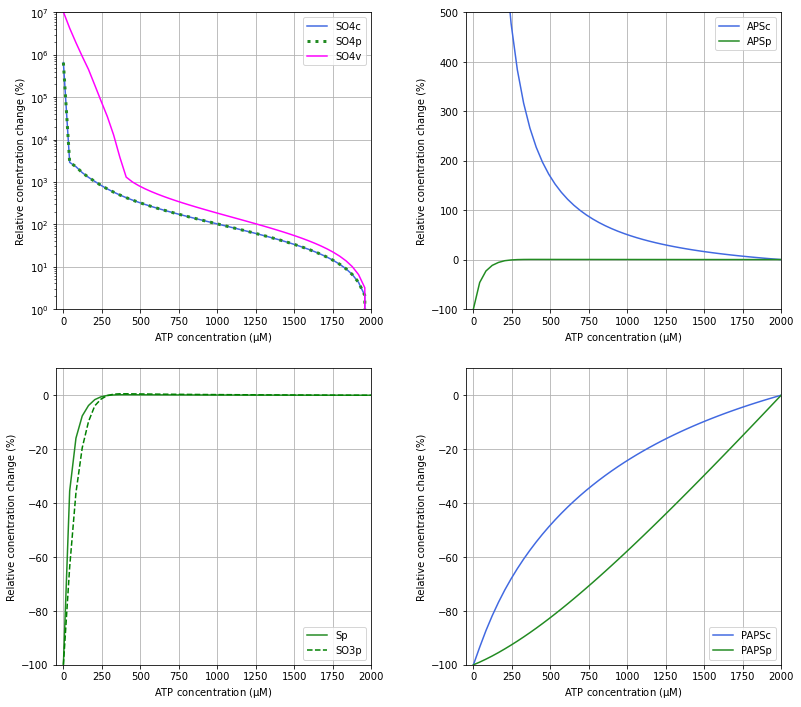

In [12]:
"""Visualise the response to ATP starvation"""
Change = ((ATP_output/True_output)-1)*100
meany = np.mean(Change, 1)
df = pd.DataFrame(meany, index=ATP_adjust_concentration, columns=Ordered_states)

fig, ([(ax, ax2), (ax3, ax4)]) = plt.subplots(2,2,figsize=(13,12))
fig.subplots_adjust(wspace=0.3)
ax.plot(ATP_adjust_concentration, 'SO4ic', data=df, color='royalblue', label='SO4c')
ax.plot(ATP_adjust_concentration, 'SO4ip', data=df, color='forestgreen', linestyle='dotted', label='SO4p', linewidth=3)
ax.plot(ATP_adjust_concentration, 'SO4iv', data=df, color='magenta', label='SO4v')
ax.legend()
ax.grid()
ax.set(yscale='log', xlabel='ATP concentration ($\mathdefault{\mu M}$)', ylabel='Relative conentration change (%)', ylim=[1, 1e7], xlim=[-50,2000])

ax2.plot(ATP_adjust_concentration, 'APSc', data=df, color='royalblue')
ax2.plot(ATP_adjust_concentration, 'APSp', data=df, color='forestgreen')
ax2.set(xlabel=('ATP concentration ($\mathdefault{\mu M}$)'), ylabel='Relative conentration change (%)', ylim=[-100, 500], xlim=[-50,2000])
ax2.legend()
ax2.grid()

ax3.plot(ATP_adjust_concentration, 'Sp', data=df, color='forestgreen')
ax3.plot(ATP_adjust_concentration, 'SO3p', data=df, color='green', linestyle='dashed')
ax3.set(xlabel='ATP concentration ($\mathdefault{\mu M}$)', ylabel='Relative conentration change (%)', ylim=[-100,10], xlim=[-50,2000])
ax3.legend()
ax3.grid()

ax4.plot(ATP_adjust_concentration, 'PAPSc', data=df, color='royalblue')
ax4.plot(ATP_adjust_concentration, 'PAPSp', data=df, color='forestgreen')
ax4.set(xlabel='ATP concentration ($\mathdefault{\mu M}$) ', ylabel='Relative conentration change (%)', ylim=[-100,10], xlim=[-50,2000])
ax4.legend(loc='lower right')
ax4.grid()
plt.show()

# Metabolic control analysis

Metabolic control of sulphation

## Flux control coefficients

Flux control at standard conditions

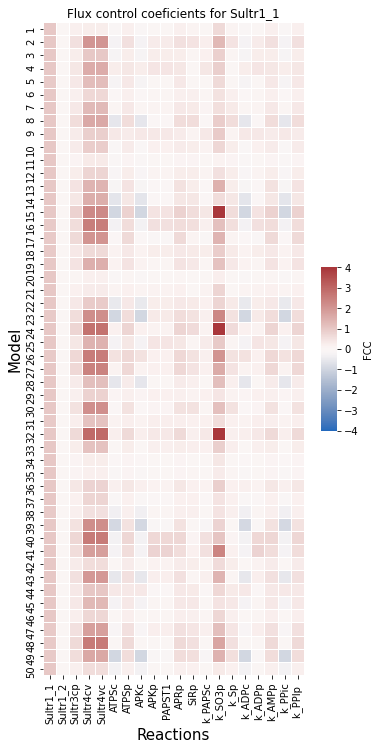

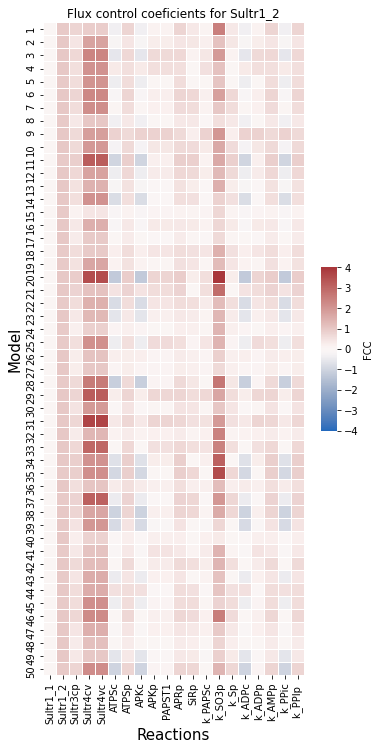

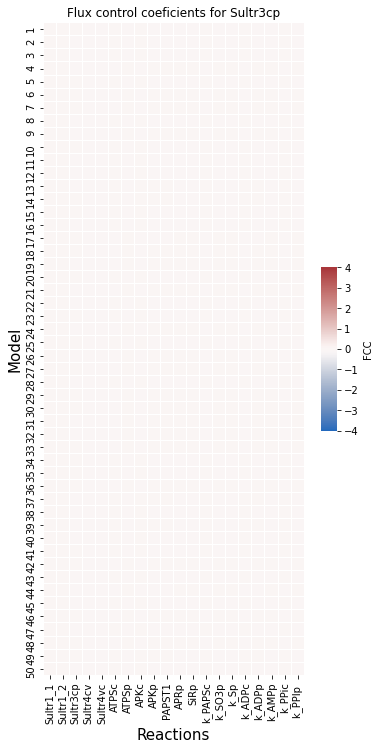

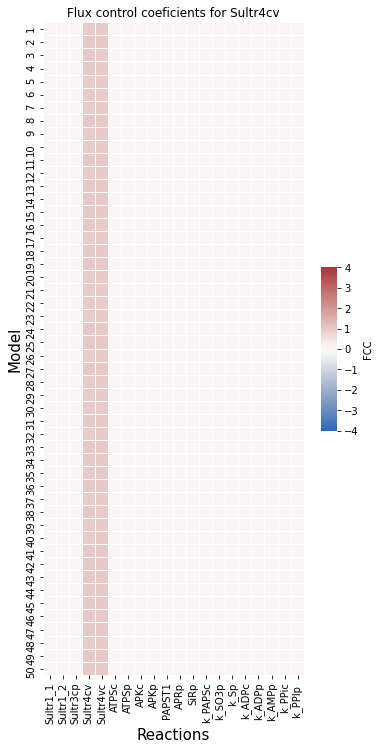

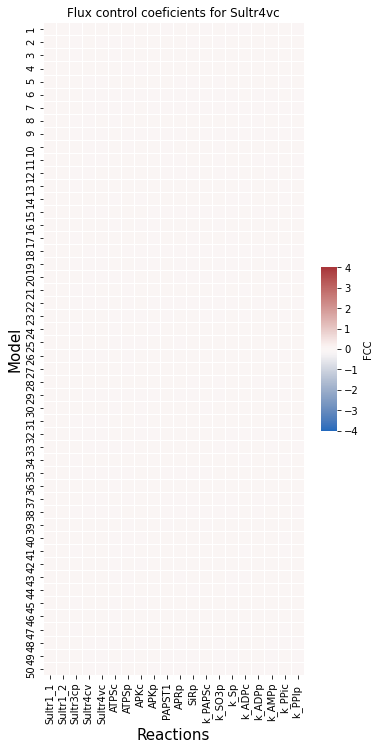

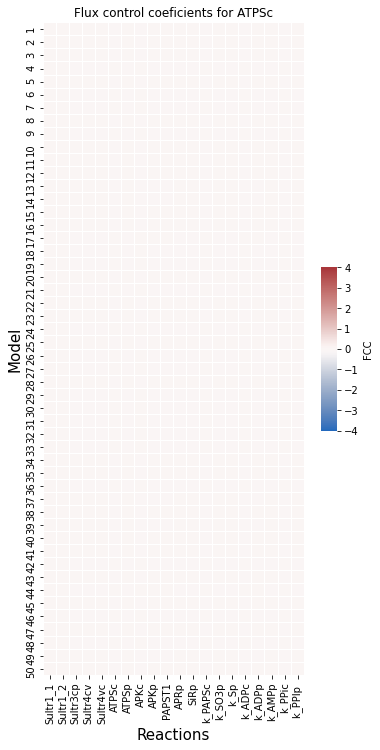

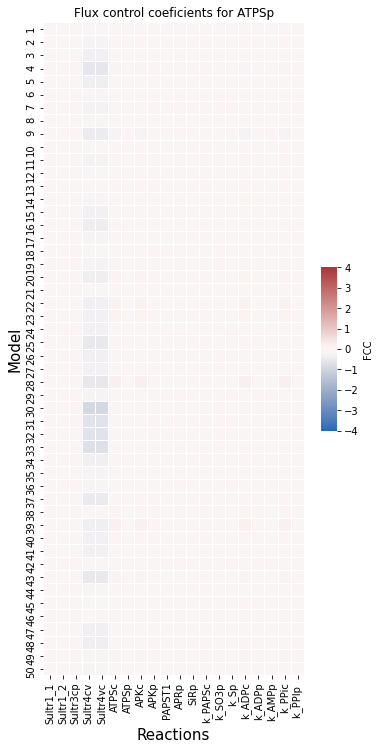

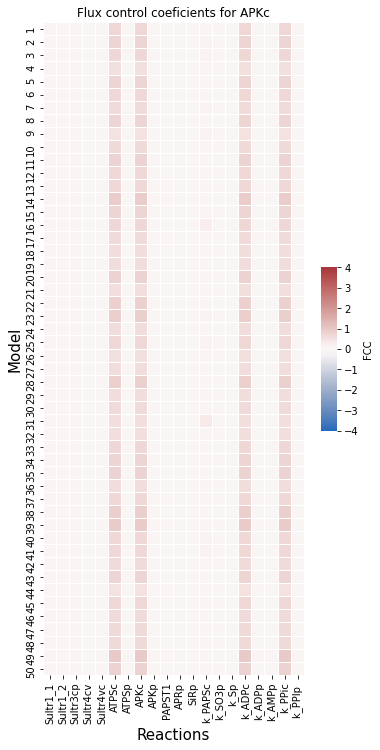

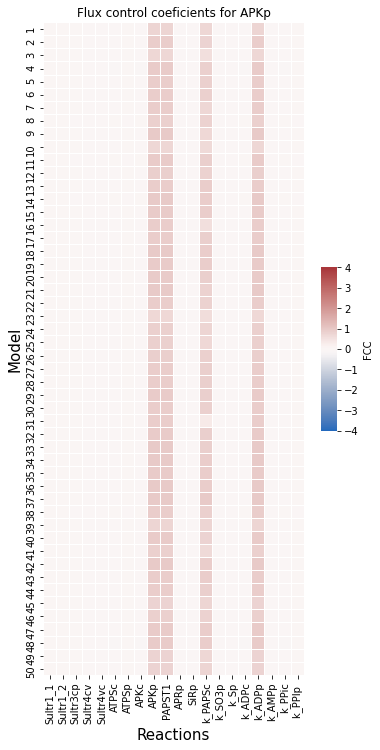

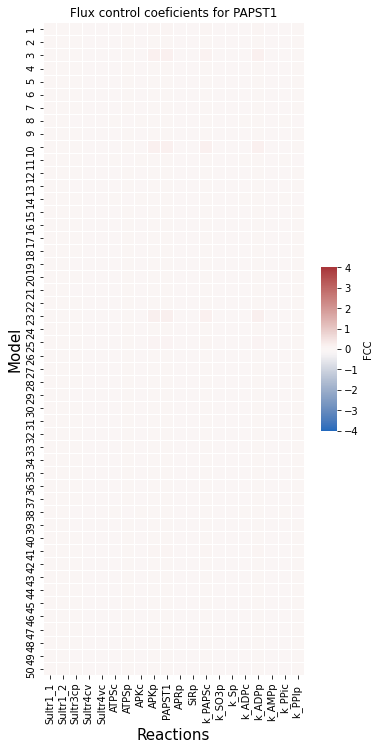

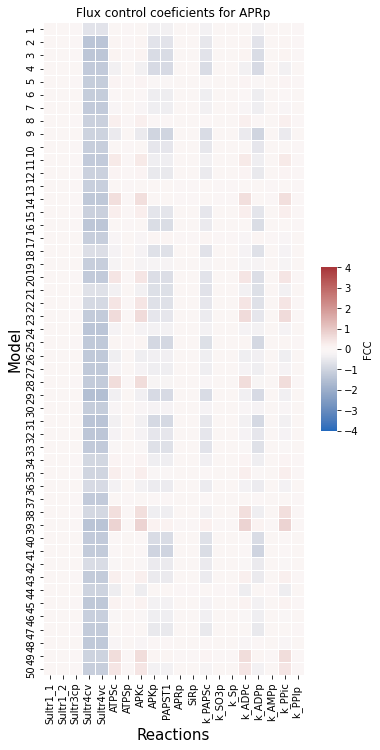

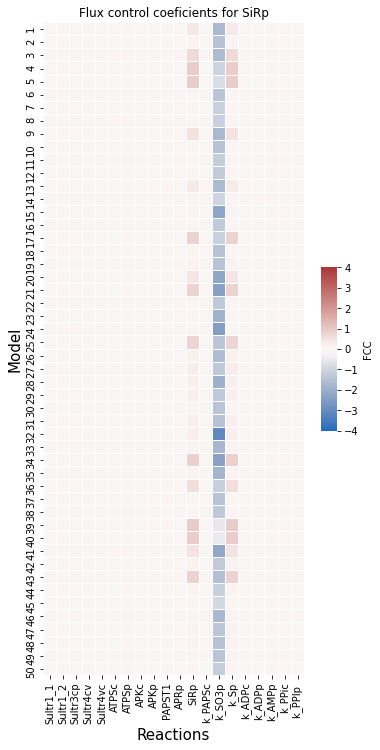

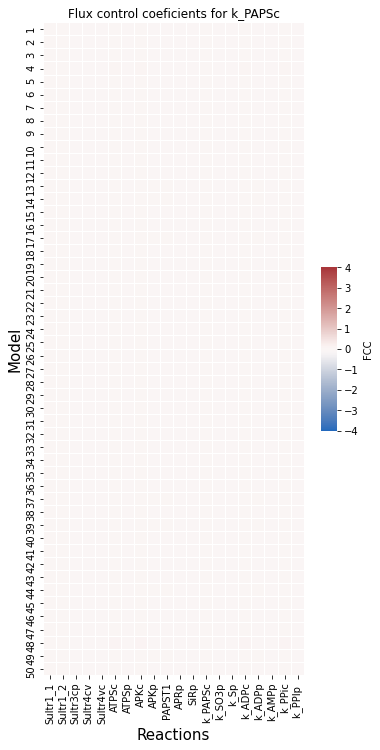

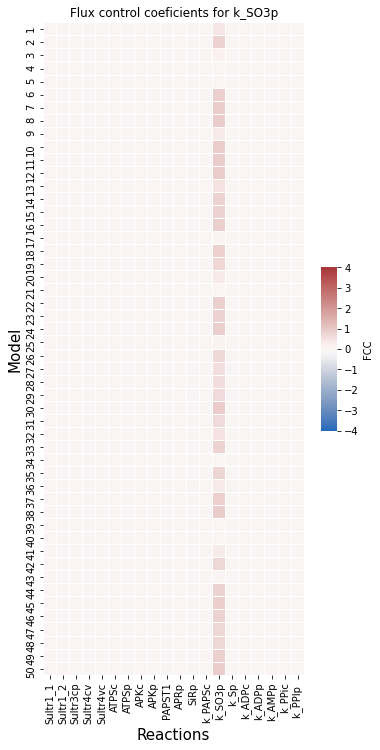

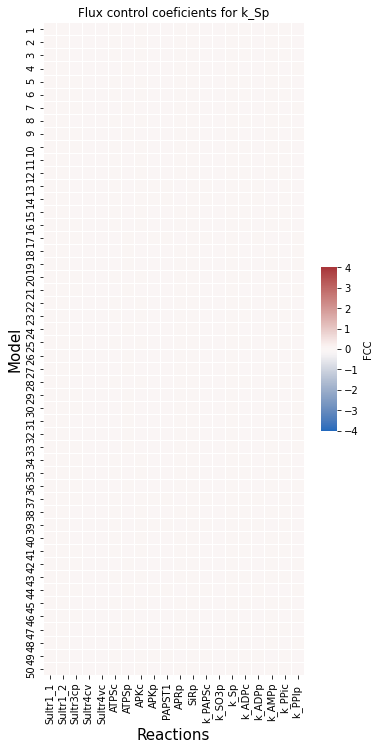

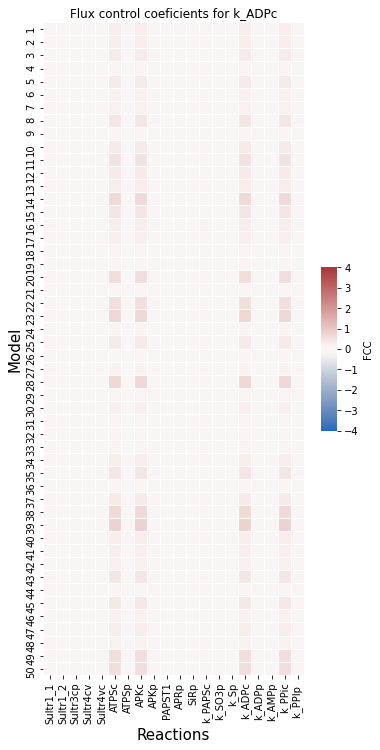

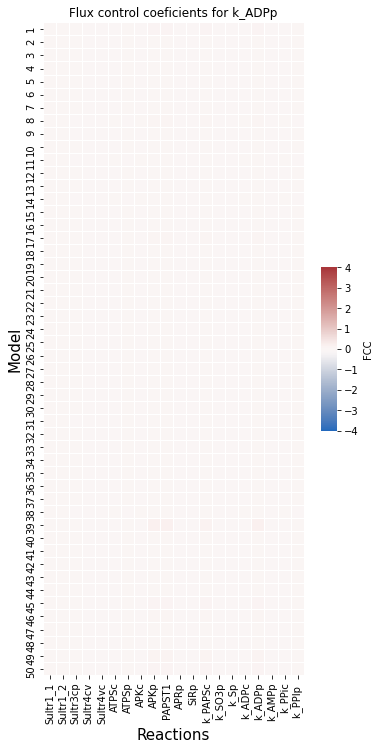

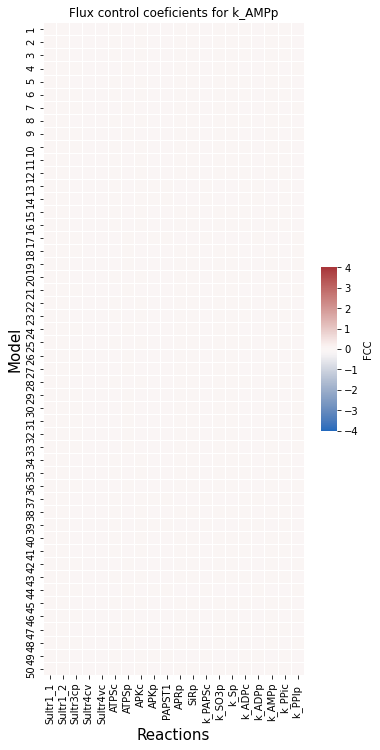

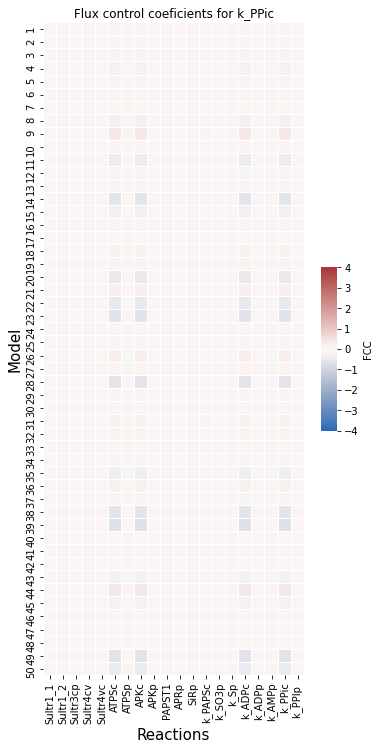

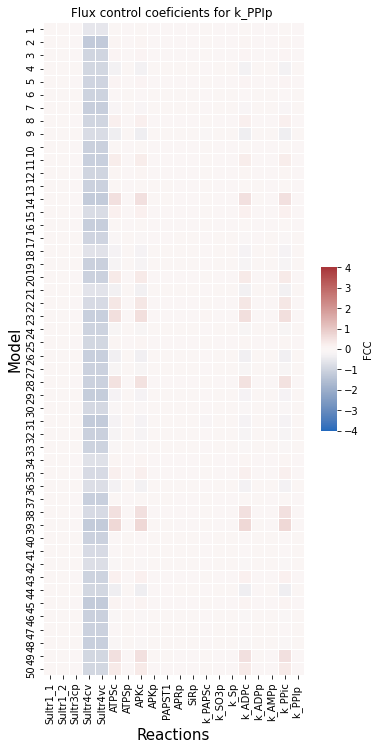

In [13]:
Flux_reactions = np.empty((20, 50, 20))
Actual_reactions = np.empty((50, 20))

for i in range(50):
    Actual_reactions[i] = Flux_test(True_output[i], All_params[i], Adjust)
    for j in range(len(Adjust)):
        Adjust[j] =1.2
        Flux_reactions[j,i] = Flux_test(Flux_output[j,i], All_params[i], Adjust)
        Adjust[j]=1    
        
flux_change = ((Flux_reactions-Actual_reactions)/Actual_reactions)/(0.2/1)
include = np.array([0, 1, 7, 8, 10, 11])
for i in range(len(Ordered_reactions)):
    df = pd.DataFrame(flux_change[i], index=np.arange(1,51), columns=Ordered_reactions)
    fig,ax = plt.subplots(figsize=(6,12))
    sns.heatmap(ax=ax, data=df, center=0, cmap="vlag", linewidths=0.005, square=True, vmax=4, vmin=-4,cbar_kws={'shrink':0.25, 'aspect':10, 'label':'FCC'})
    ax.set_xlabel('Reactions', fontsize=15)
    ax.set_ylabel('Model', fontsize=15)
    ax.set_title('Flux control coeficients for {}'.format(Ordered_reactions[i]), fontsize=12)

Flux control at sulphate starvation

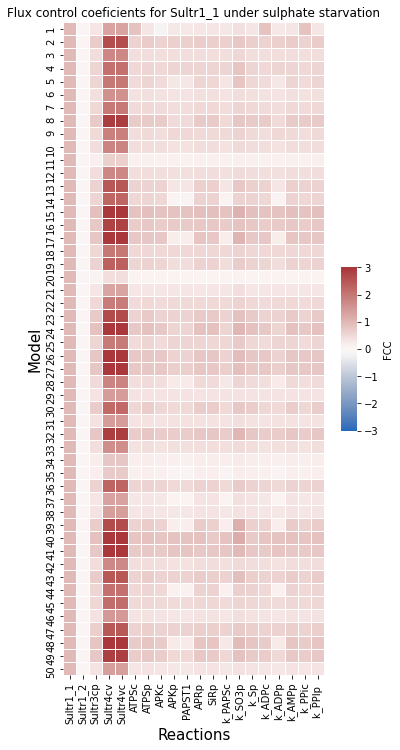

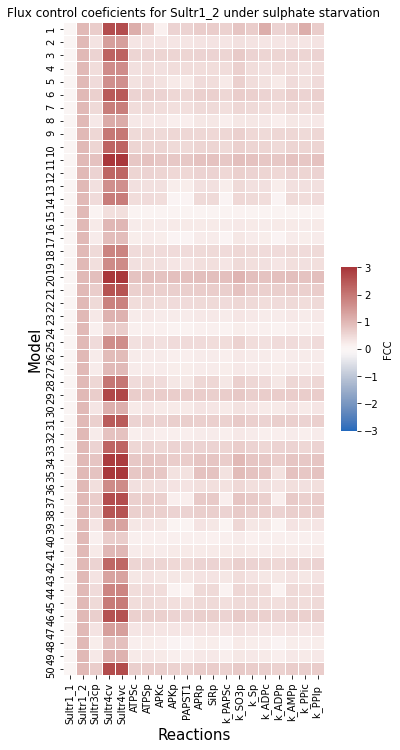

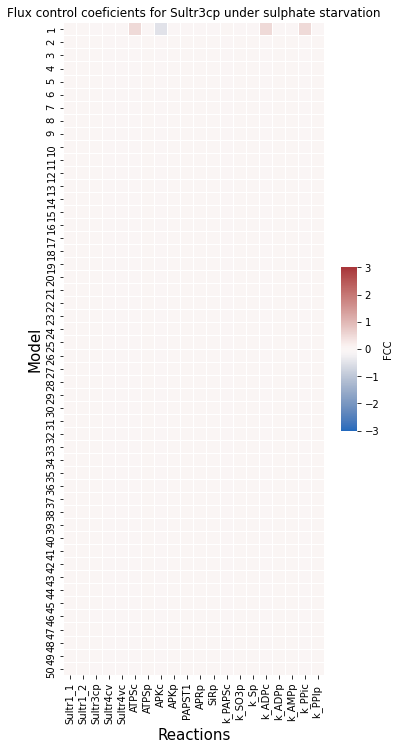

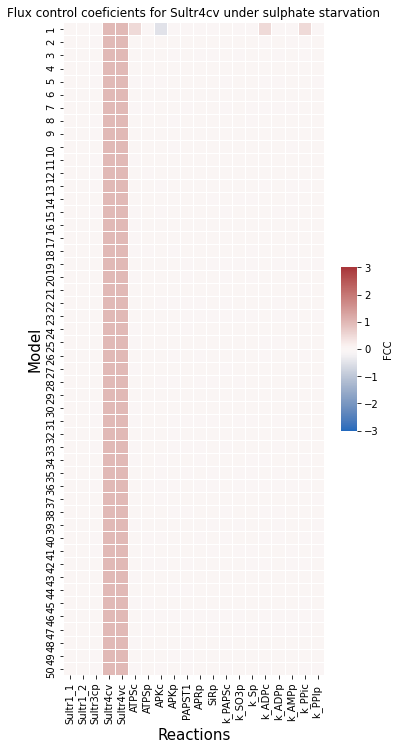

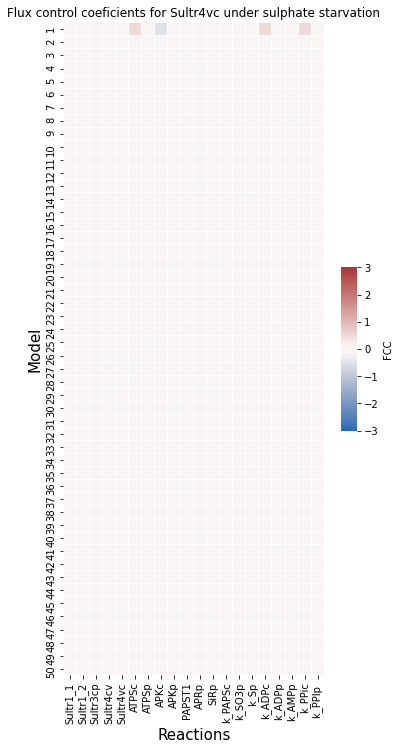

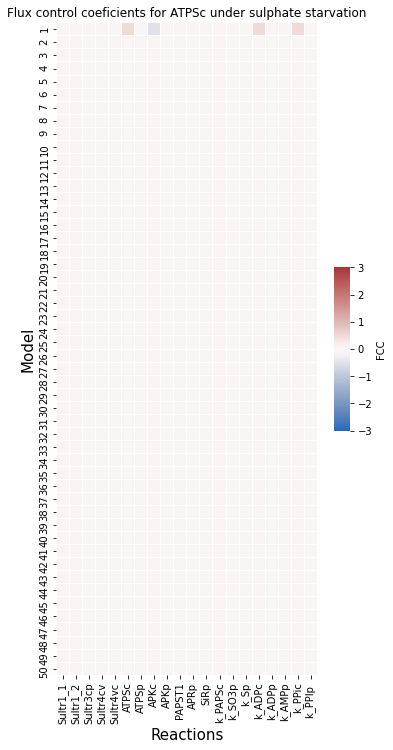

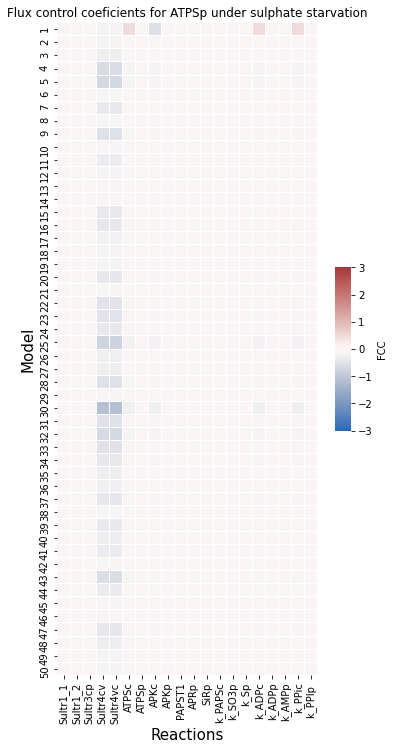

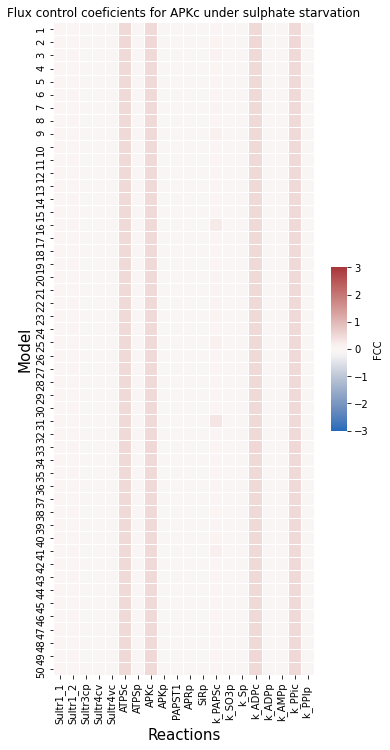

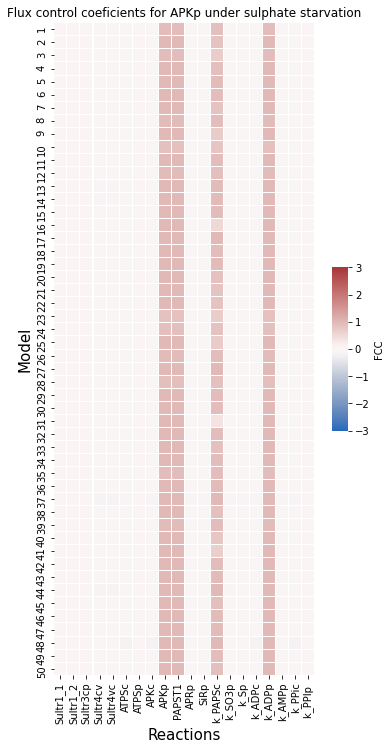

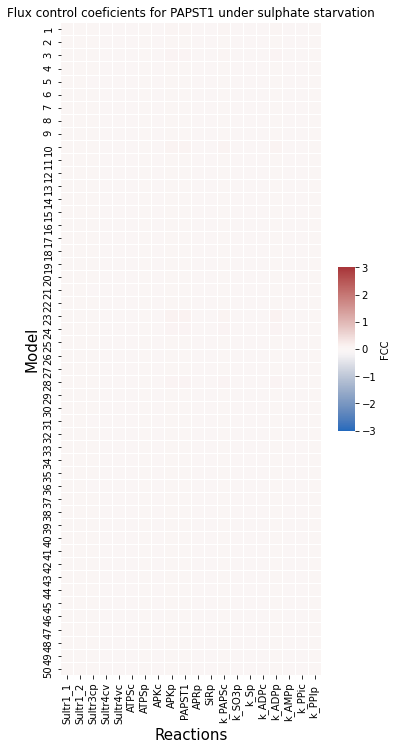

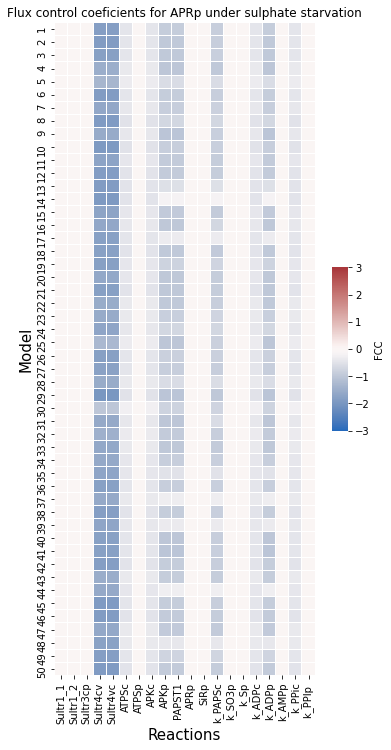

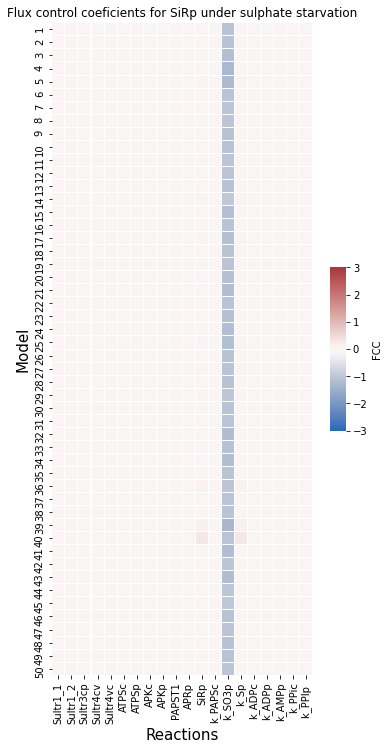

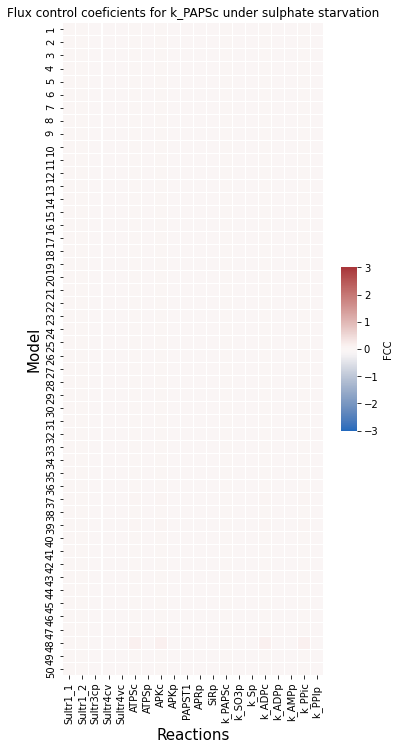

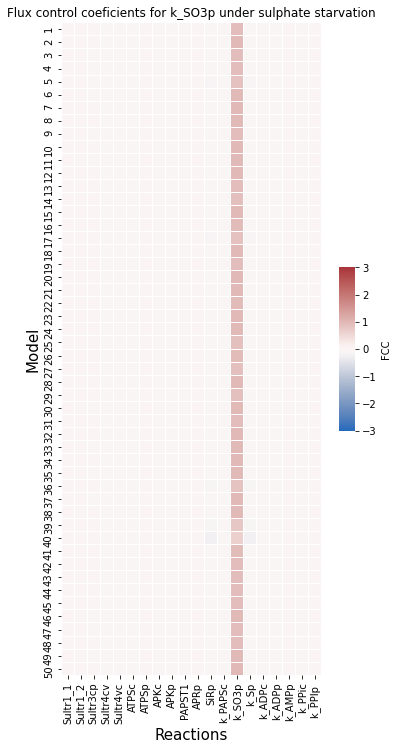

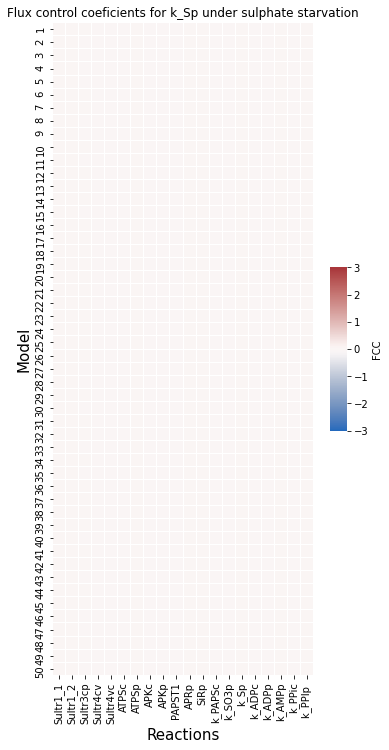

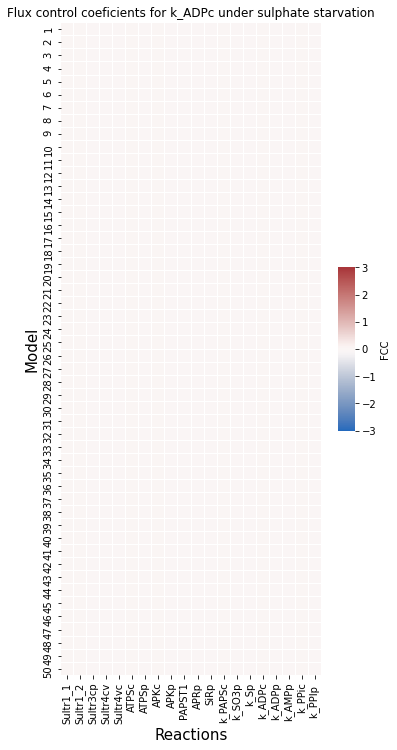

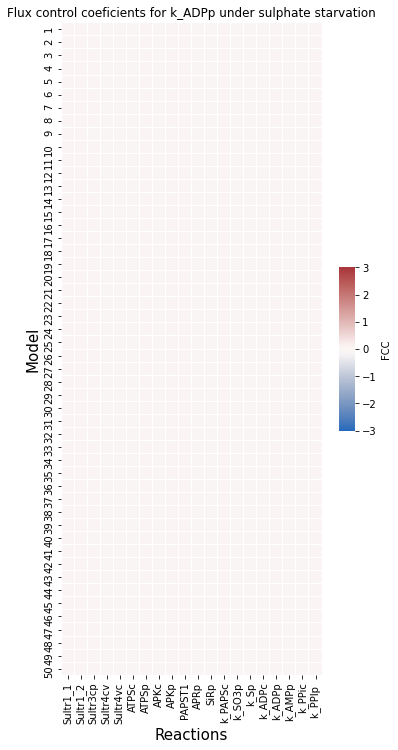

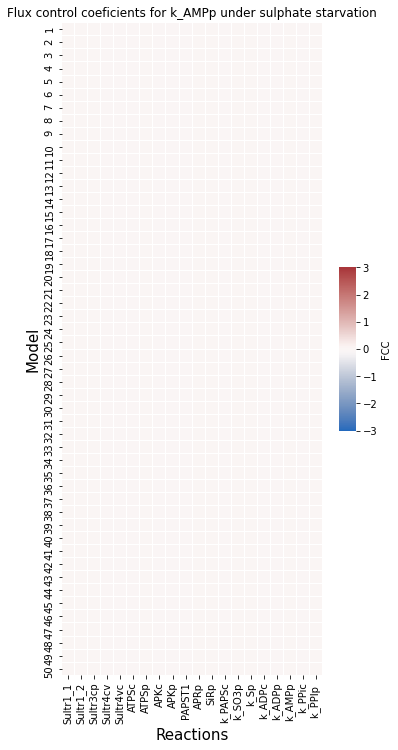

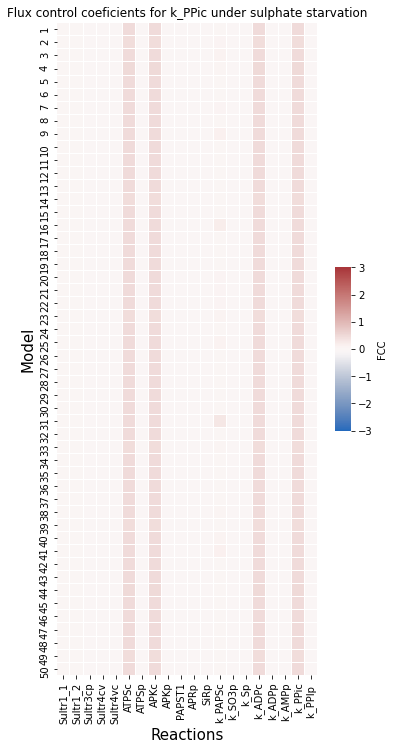

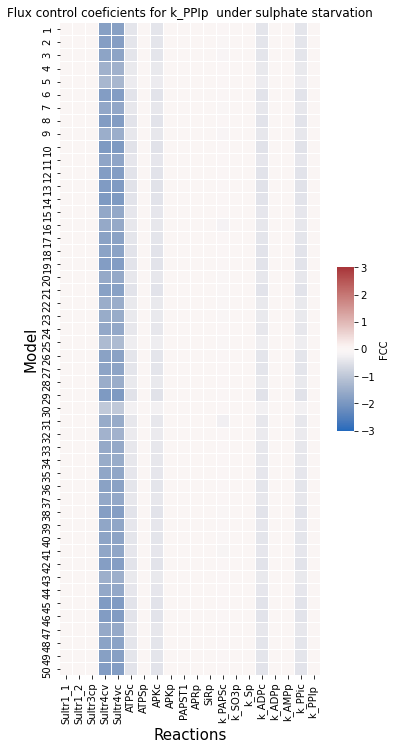

In [14]:
"""Visualise FCCs for individual reactions under SO4 starvation"""
flux_change_so4_starve = np.log(SO4_starve_Flux_reactions/SO4_starve_Actual_reactions)/np.log(1.2)

for i in range(len(Ordered_reactions)):
    df = pd.DataFrame(flux_change_so4_starve[i], index=np.arange(1,51), columns=Ordered_reactions)
    fig,ax = plt.subplots(figsize=(6,12))
    sns.heatmap(ax=ax, data=df, center=0, cmap="vlag", linewidths=0.005, square=True, vmax=3, vmin=-3, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'FCC'})
    ax.set_xlabel('Reactions', fontsize=15)
    ax.set_ylabel('Model', fontsize=15)
    ax.set_title('Flux control coeficients for {} under sulphate starvation'.format(Ordered_reactions[i]), fontsize=12)
    plt.show()

Flux control at ATP starvation

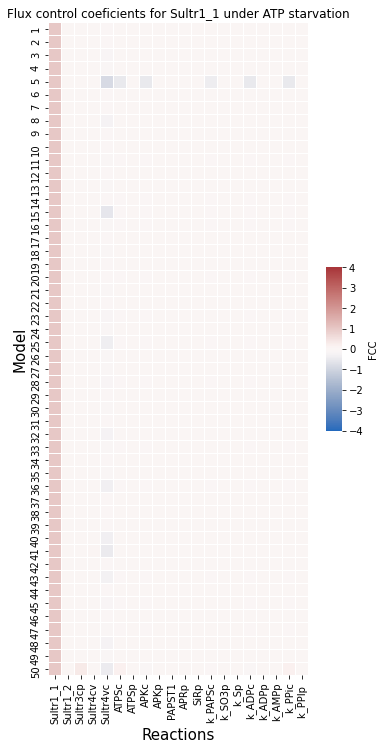

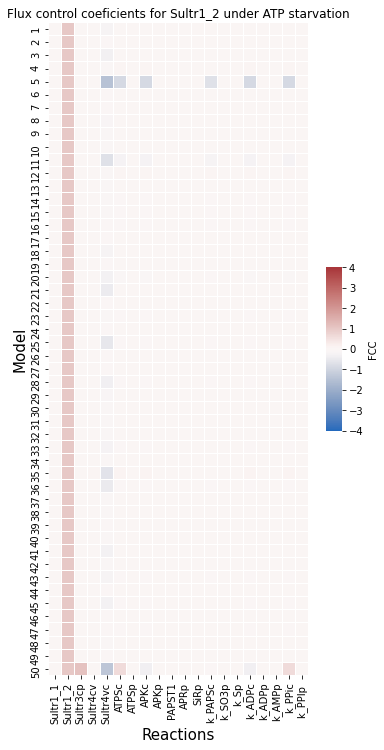

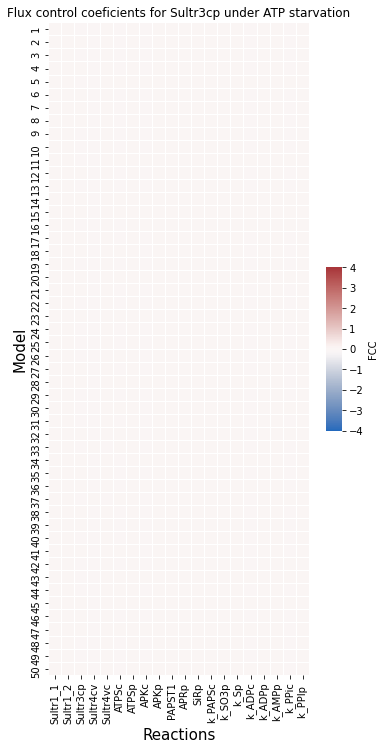

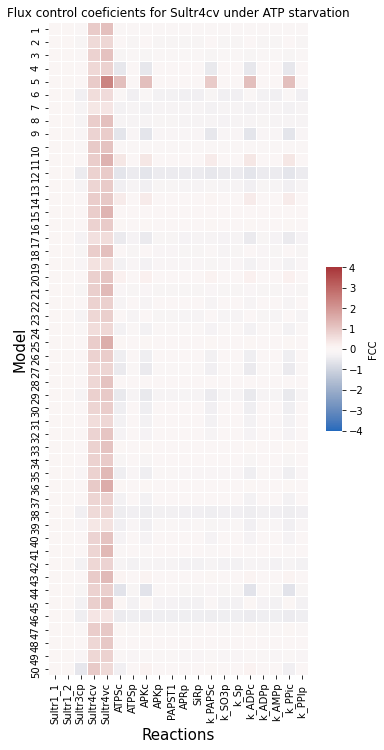

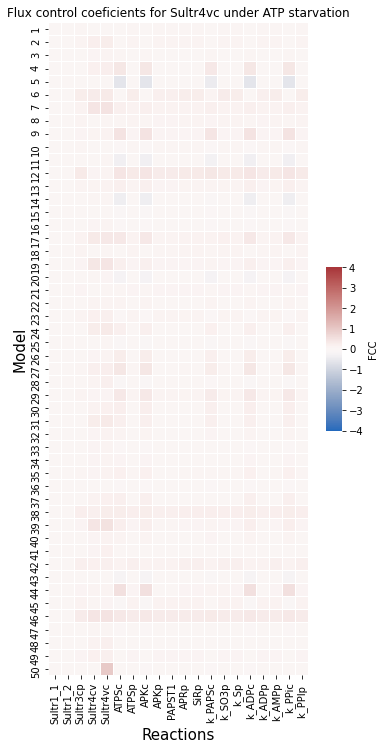

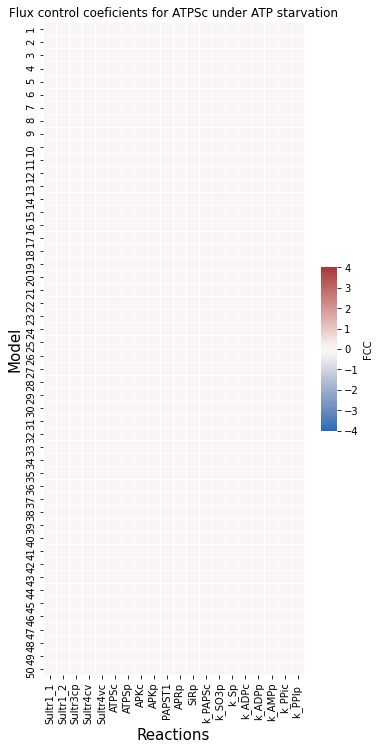

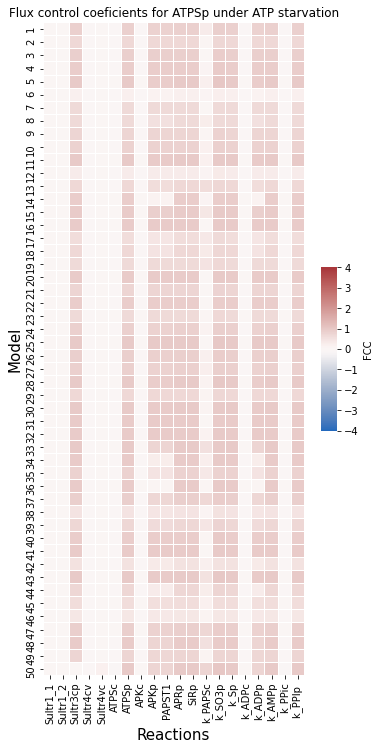

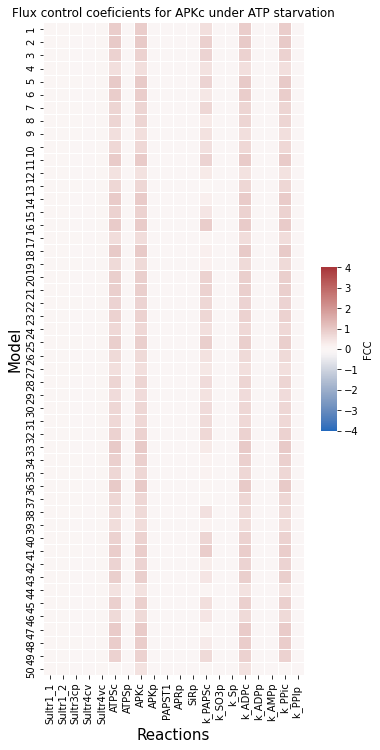

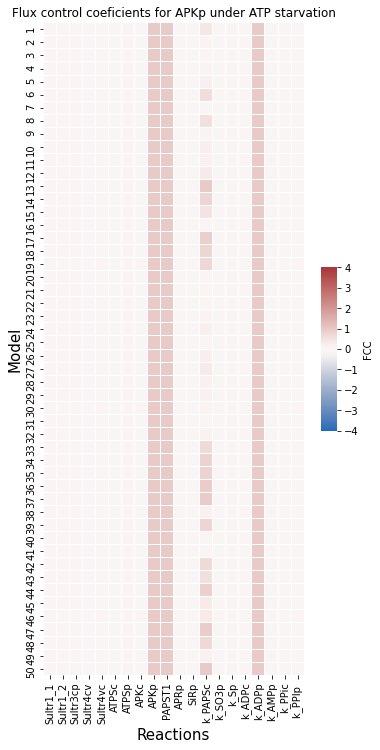

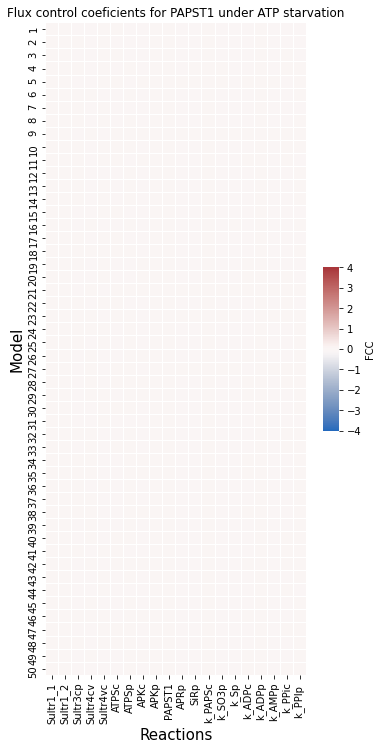

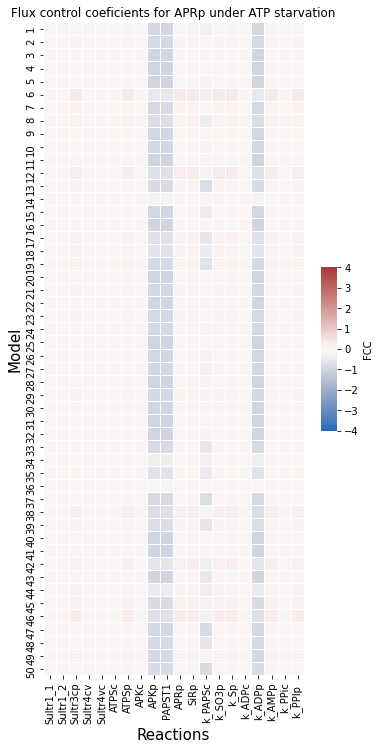

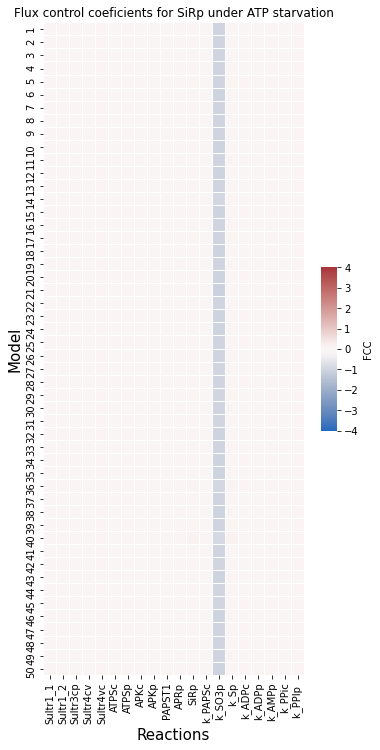

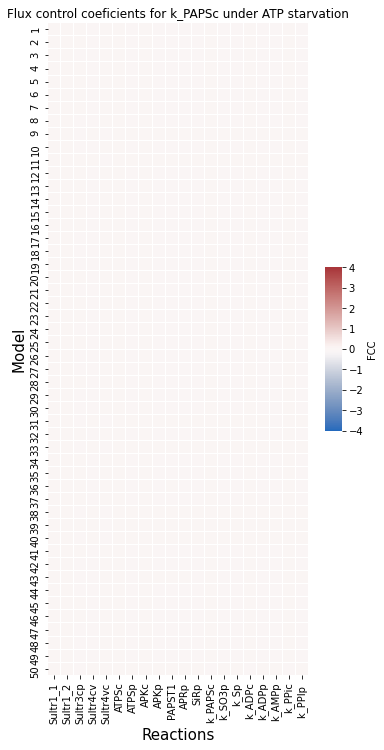

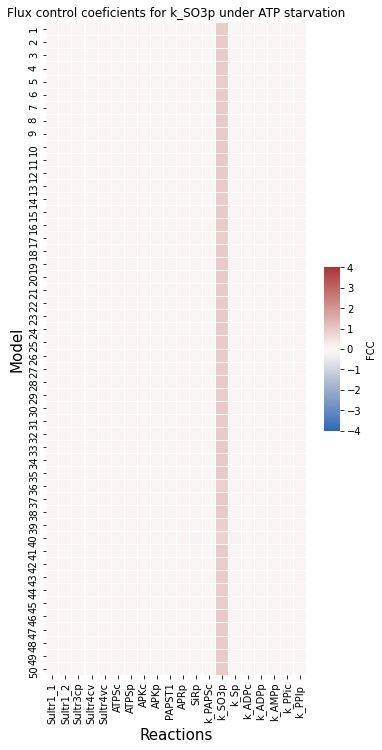

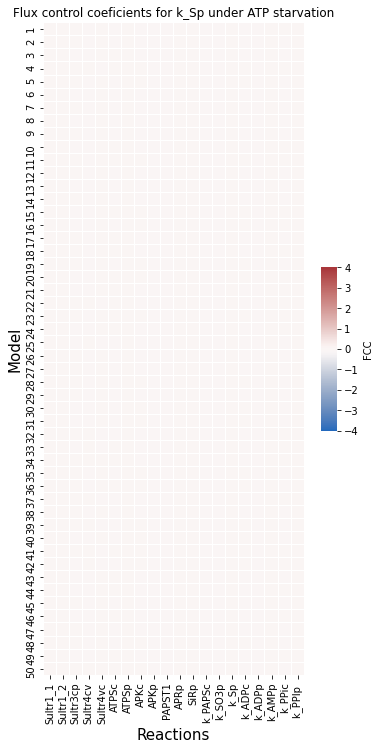

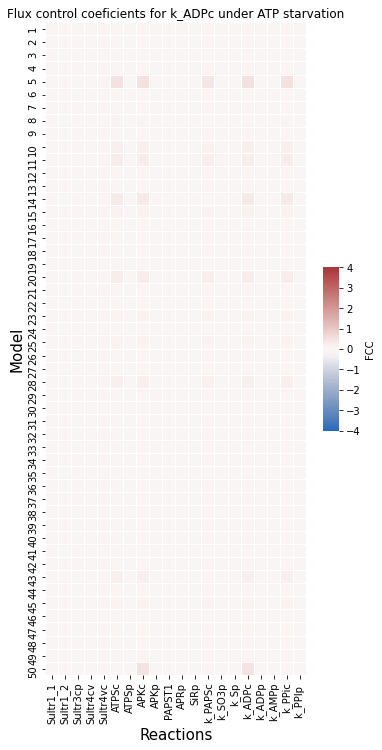

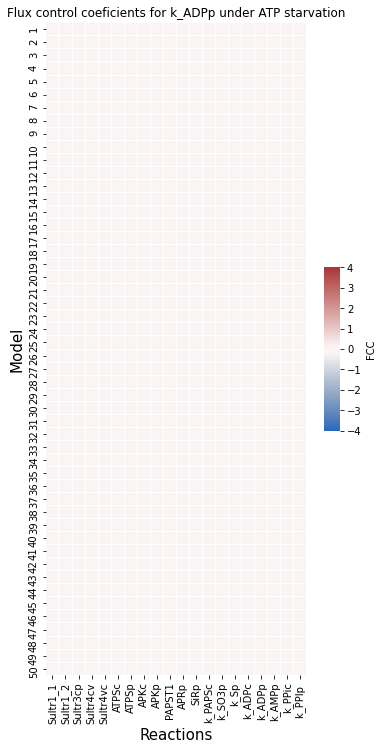

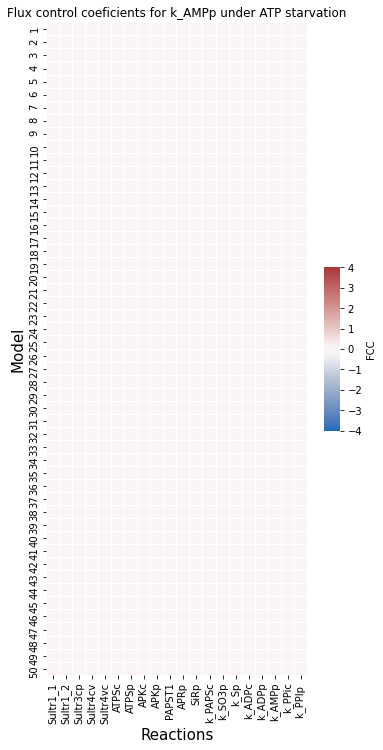

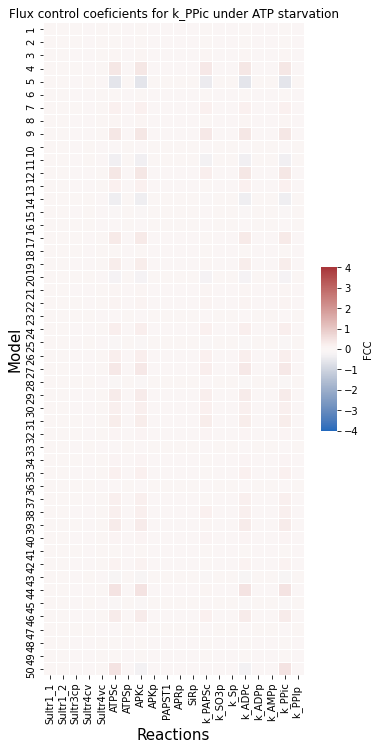

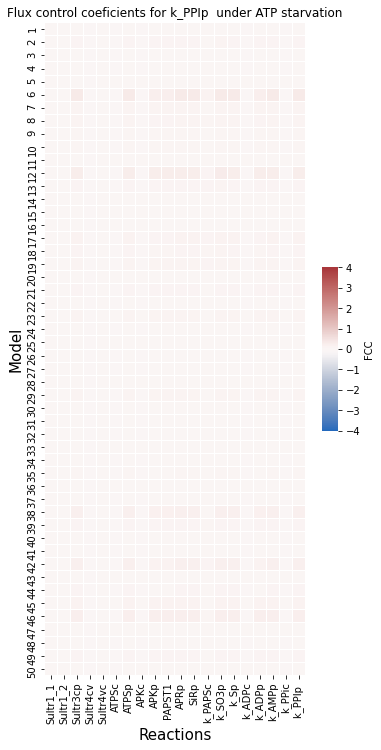

In [15]:
"""Visualise FCCs for individual reactions under ATP starvation"""
flux_change_atp_starve = np.log(ATP_starve_Flux_reactions/ATP_starve_Actual_reactions)/np.log(1.2)

for i in range(len(Ordered_reactions)):
    df = pd.DataFrame(flux_change_atp_starve[i], index=np.arange(1,51), columns=Ordered_reactions)
    fig,ax = plt.subplots(figsize=(6,12))
    sns.heatmap(ax=ax, data=df, center=0, cmap="vlag", linewidths=0.005, square=True, vmin=-4, vmax=4, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'FCC'})
    ax.set_xlabel('Reactions', fontsize=15)
    ax.set_ylabel('Model', fontsize=15)
    ax.set_title('Flux control coeficients for {} under ATP starvation'.format(Ordered_reactions[i]), fontsize=12)

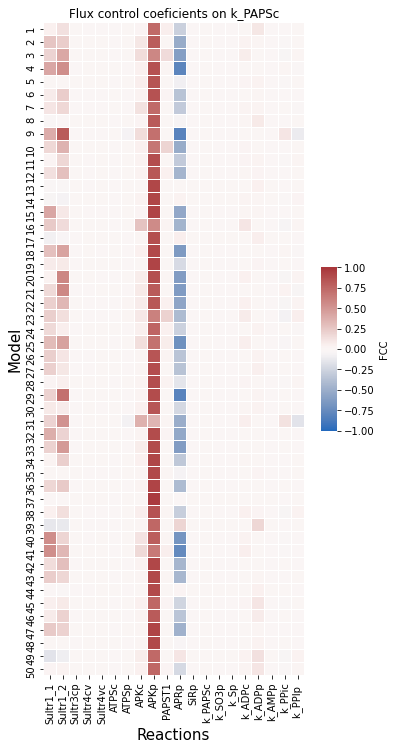

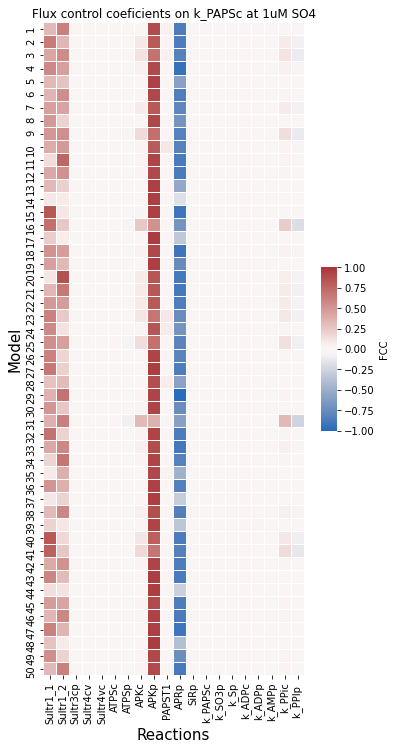

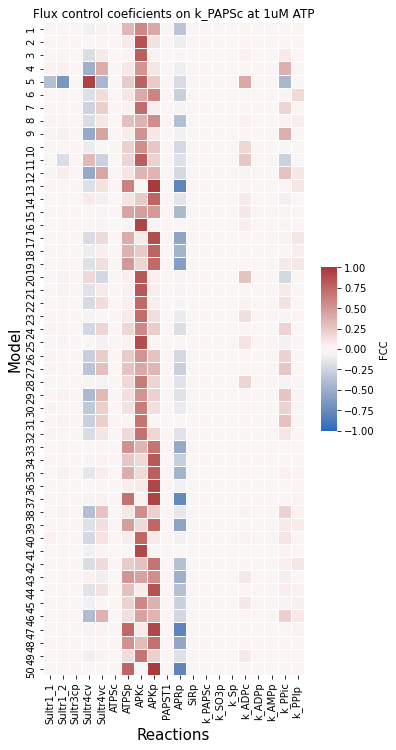

In [16]:
"""Visualise FCCs on PAPS consumption"""
DF_flux_change = pd.DataFrame((np.swapaxes(flux_change[:,:,12], 0, 1)), index=np.arange(1,51), columns=Ordered_reactions)
DF_flux_change_so4_starve = pd.DataFrame((np.swapaxes(flux_change_so4_starve[:,:,12], 0, 1)), index=np.arange(1,51), columns=Ordered_reactions)
DF_flux_change_atp_starve = pd.DataFrame((np.swapaxes(flux_change_atp_starve[:,:,12], 0, 1)), index=np.arange(1,51), columns=Ordered_reactions)

fig,ax = plt.subplots(figsize=(6,12))
sns.heatmap(ax=ax, data=DF_flux_change, center=0, cmap="vlag", linewidths=0.005, square=True, vmax=1, vmin=-1, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'FCC'})
ax.set_xlabel('Reactions', fontsize=15)
ax.set_ylabel('Model', fontsize=15)
ax.set_title('Flux control coeficients on {}'.format(Ordered_reactions[12]), fontsize=12)
plt.show()

fig,ax = plt.subplots(figsize=(6,12))
sns.heatmap(ax=ax, data=DF_flux_change_so4_starve, center=0, cmap="vlag", linewidths=0.005, square=True, vmax=1, vmin=-1, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'FCC'})
ax.set_xlabel('Reactions', fontsize=15)
ax.set_ylabel('Model', fontsize=15)
ax.set_title('Flux control coeficients on {} at 1uM SO4'.format(Ordered_reactions[12]), fontsize=12)
plt.show()

fig,ax = plt.subplots(figsize=(6,12))
sns.heatmap(ax=ax, data=DF_flux_change_atp_starve, center=0, cmap="vlag", linewidths=0.005, square=True, vmax=1, vmin=-1, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'FCC'})
ax.set_xlabel('Reactions', fontsize=15)
ax.set_ylabel('Model', fontsize=15)
ax.set_title('Flux control coeficients on {} at 1uM ATP'.format(Ordered_reactions[12]), fontsize=12)
plt.show()


## Concentration control coefficients

Concentration control at standard conditions

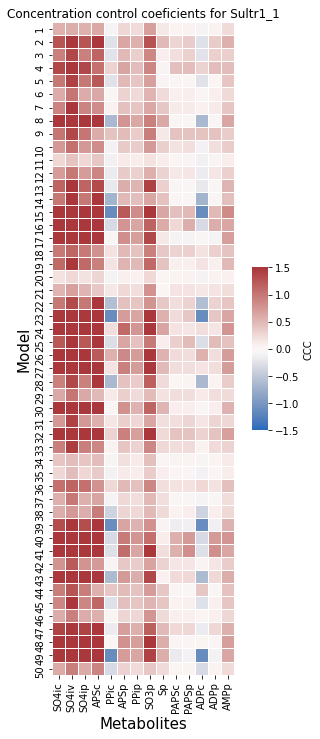

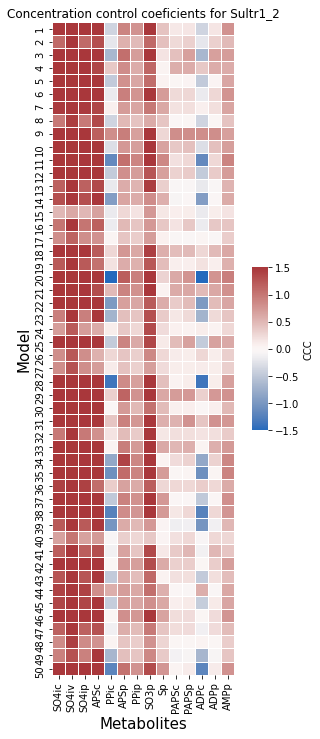

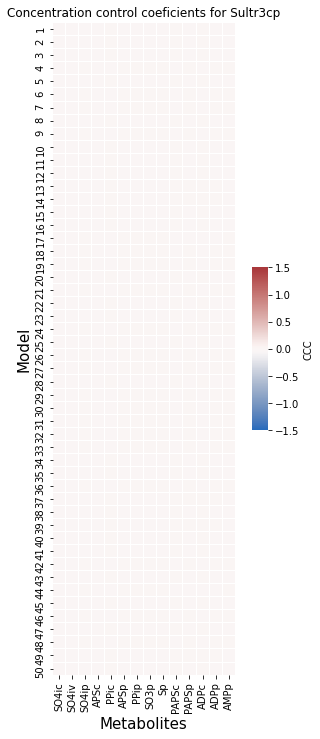

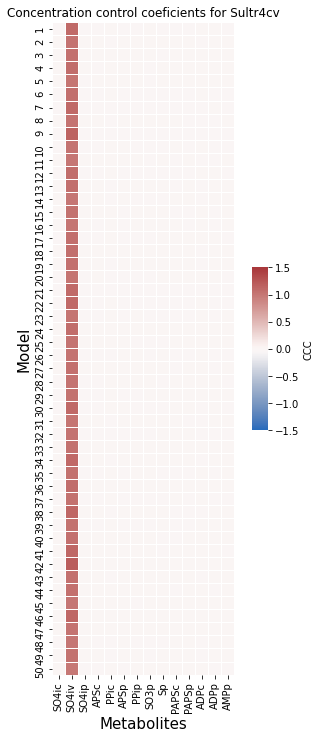

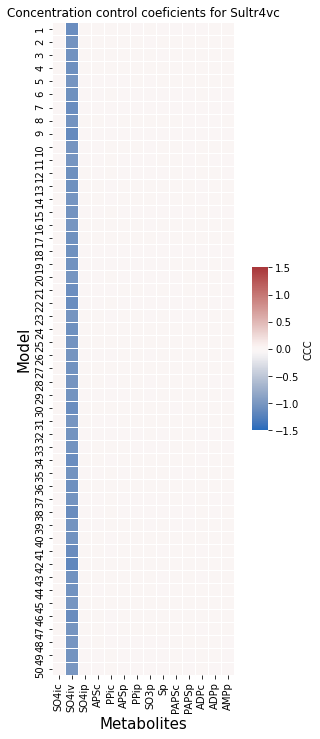

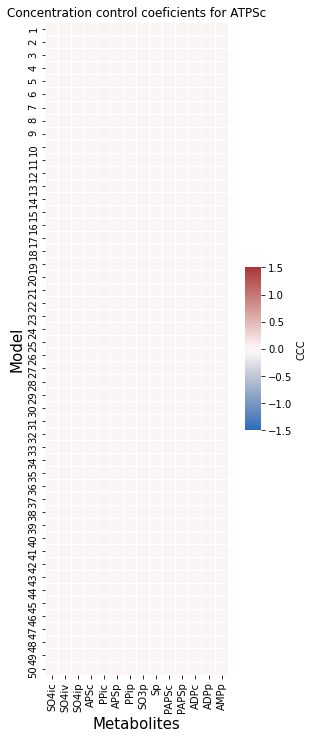

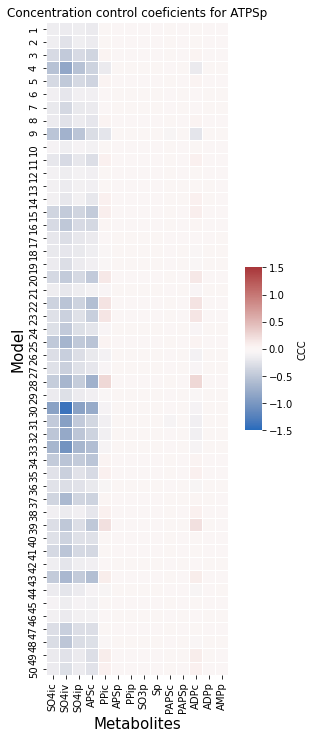

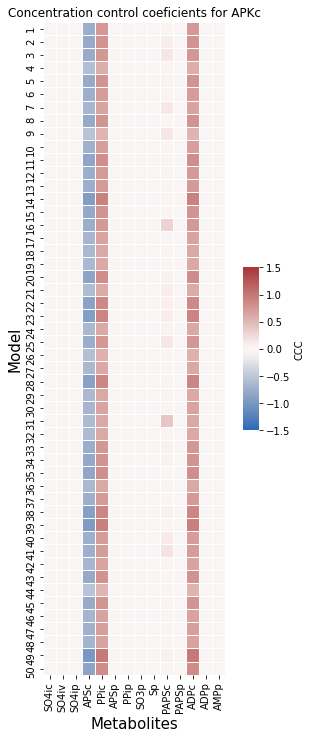

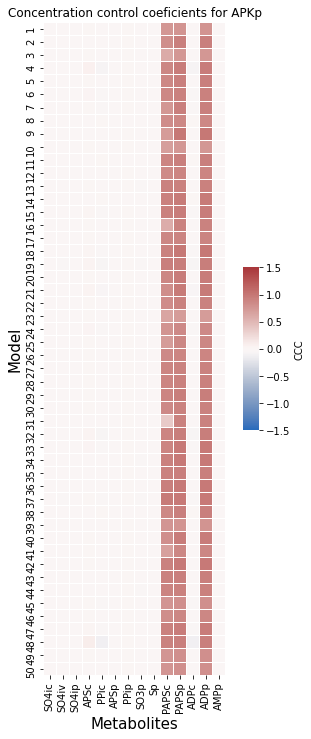

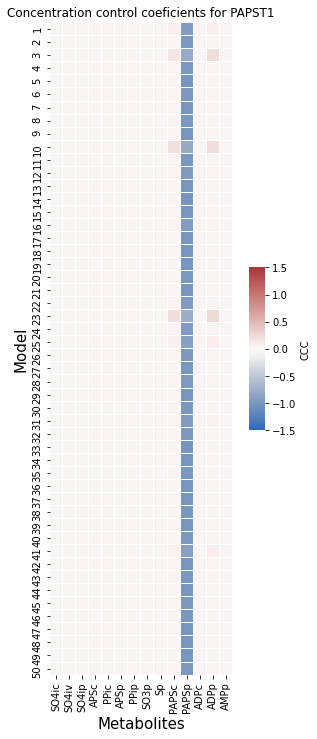

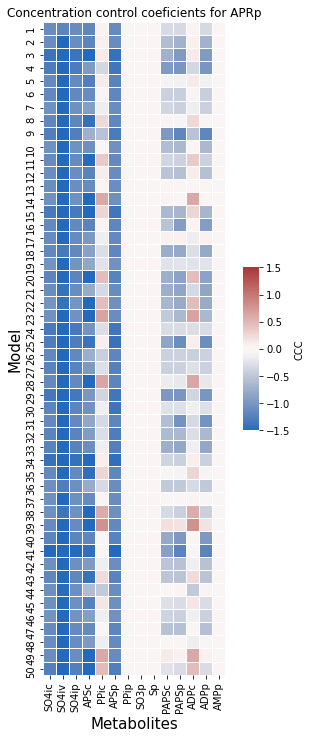

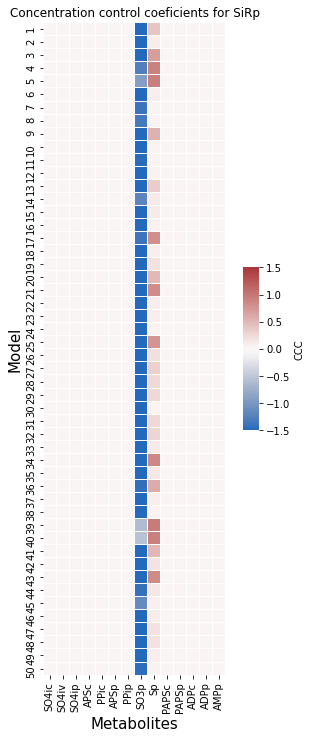

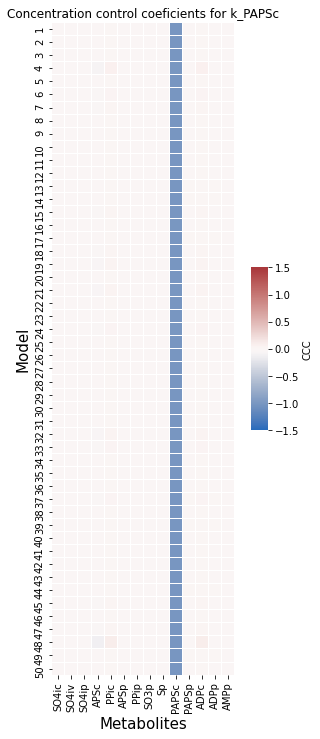

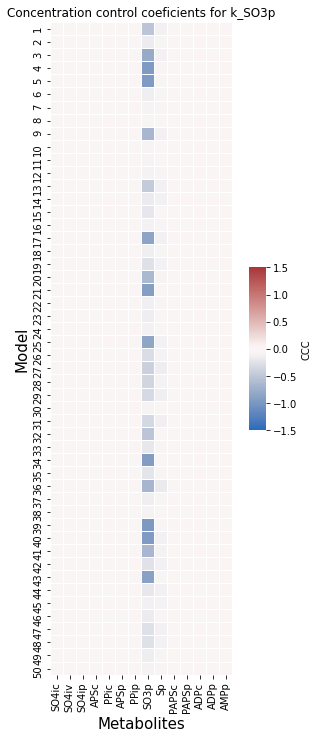

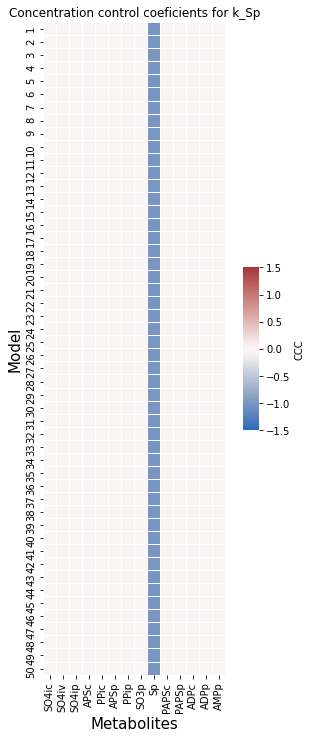

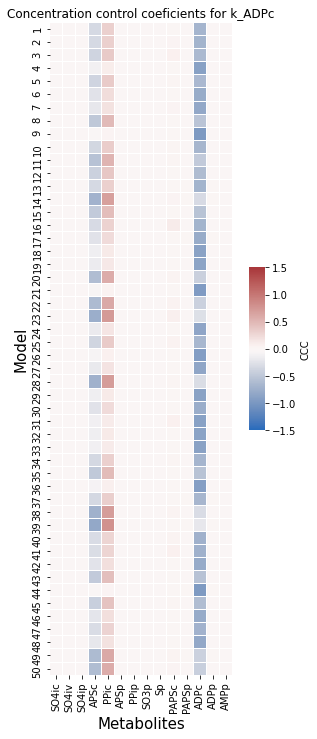

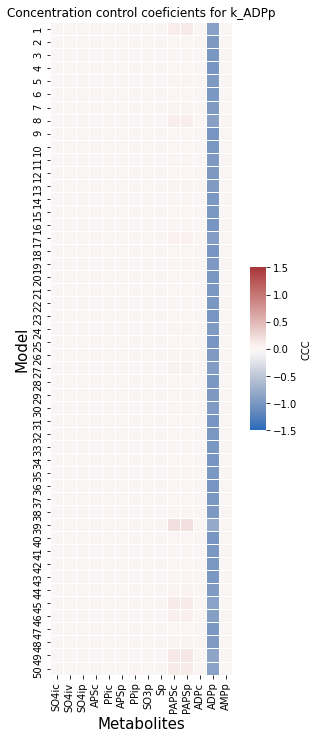

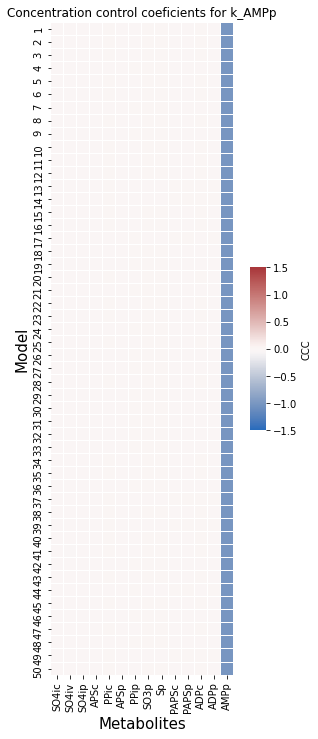

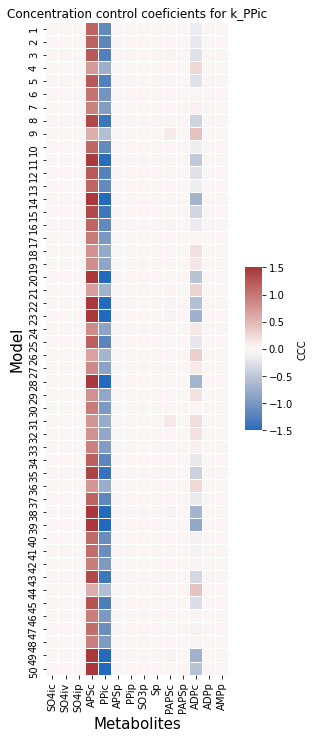

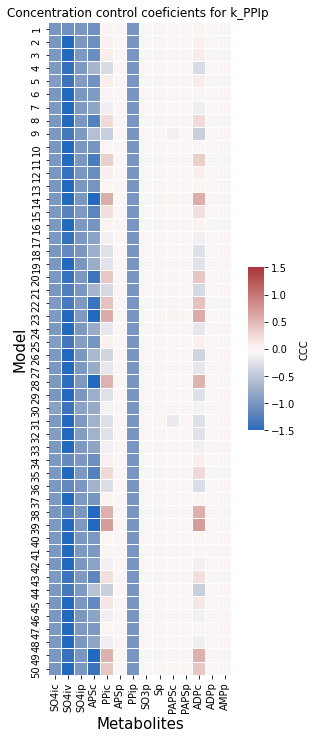

In [17]:
Conc_coef = np.log(Flux_output/True_output)/np.log(1.2)

for i in range(len(Ordered_reactions)):
    df = pd.DataFrame(Conc_coef[i], index=np.arange(1,51), columns=Ordered_states)
    fig,ax = plt.subplots(figsize=(6,12))
    sns.heatmap(ax=ax, data=df, center=0, cmap="vlag", linewidths=0.005, square=True,vmin=-1.5, vmax=1.5, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'CCC'})
    ax.set_xlabel('Metabolites', fontsize=15)
    ax.set_ylabel('Model', fontsize=15)
    ax.set_title('Concentration control coeficients for {}'.format(Ordered_reactions[i]), fontsize=12)

Concentration control at sulphate starvation

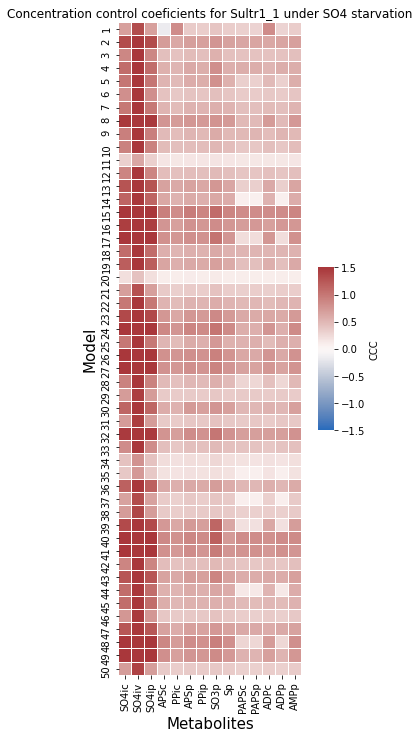

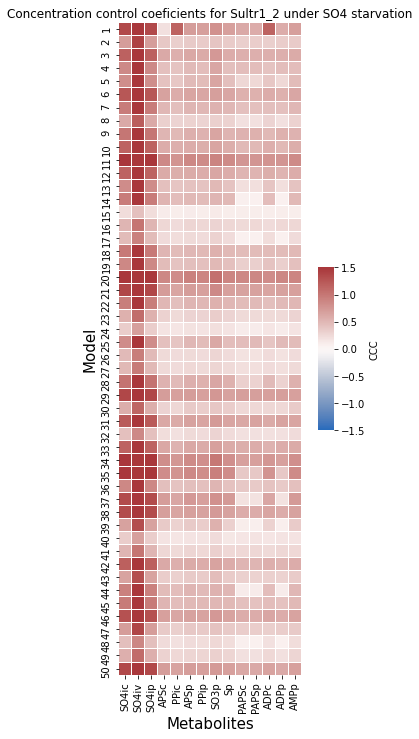

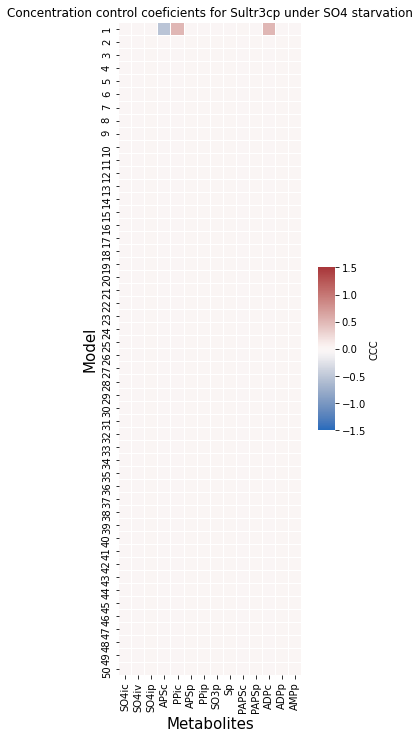

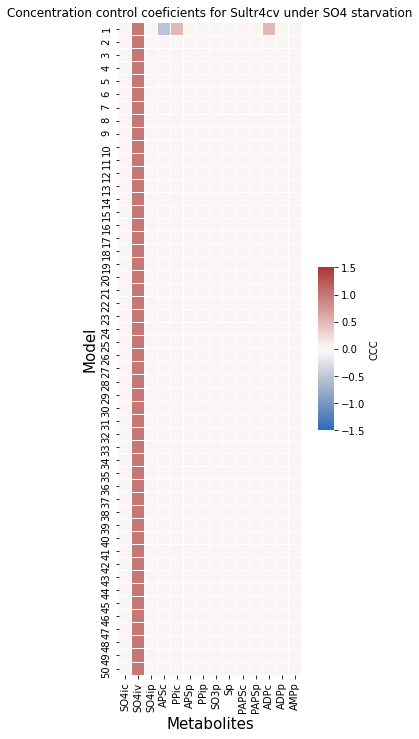

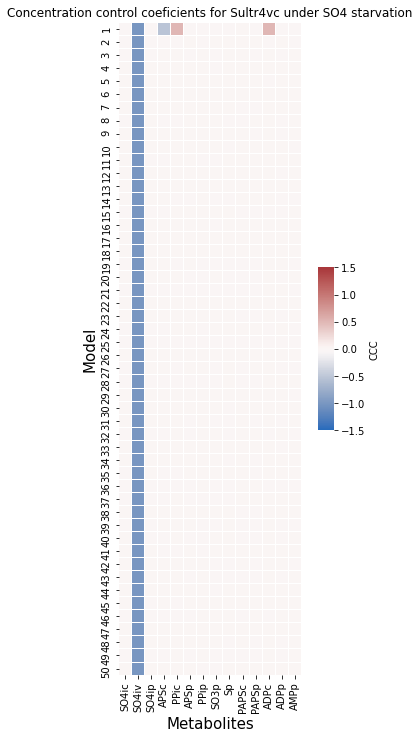

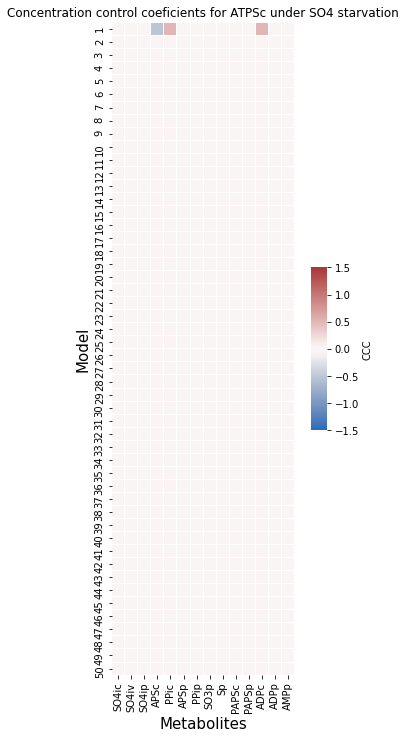

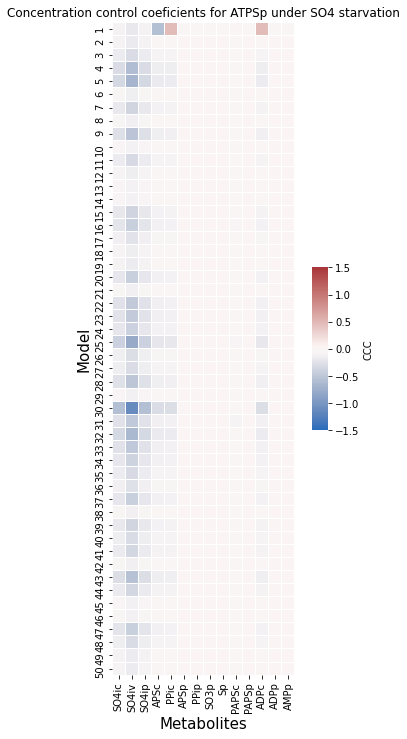

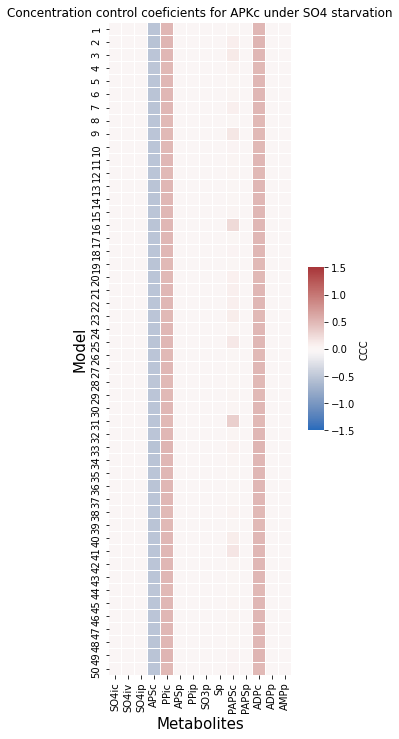

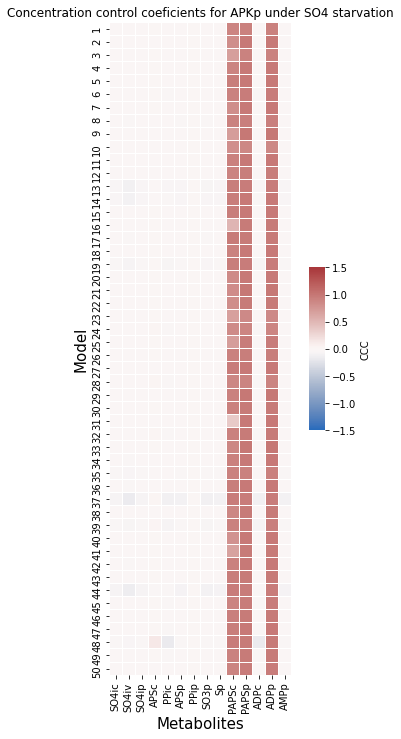

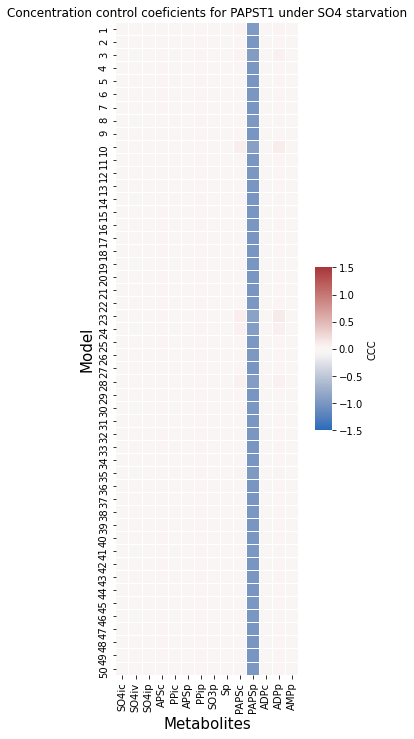

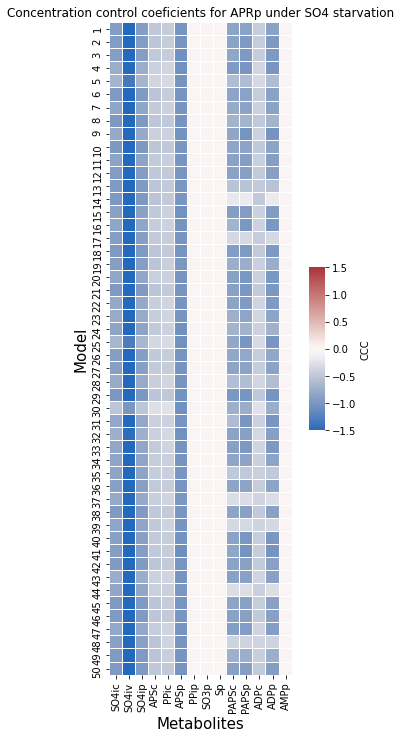

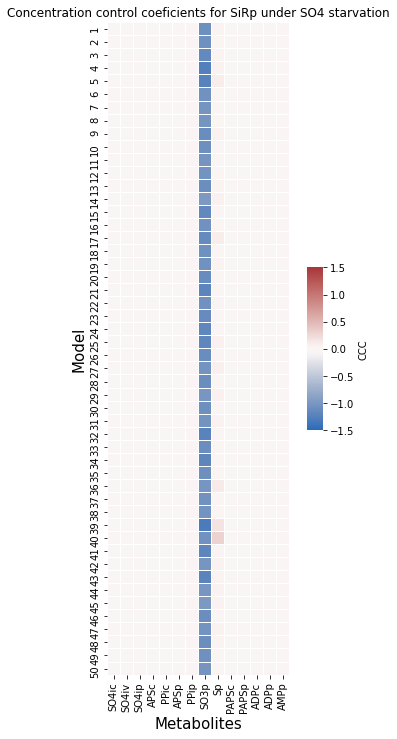

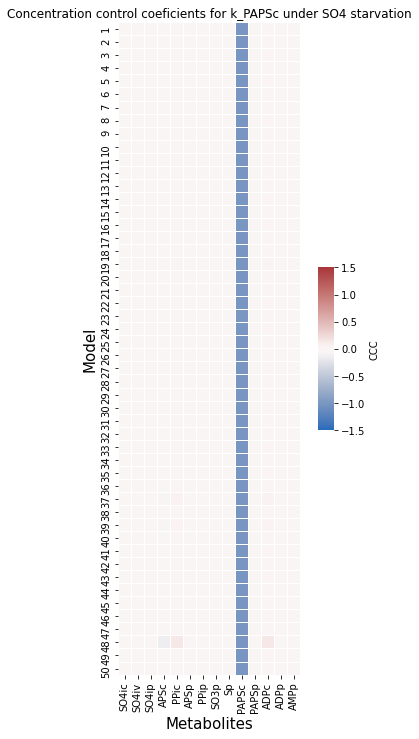

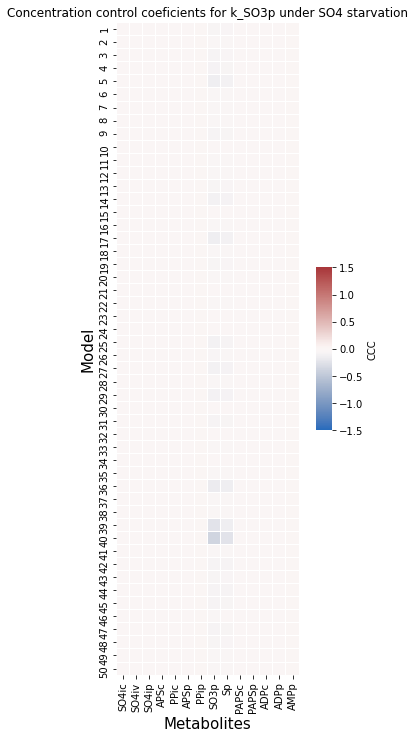

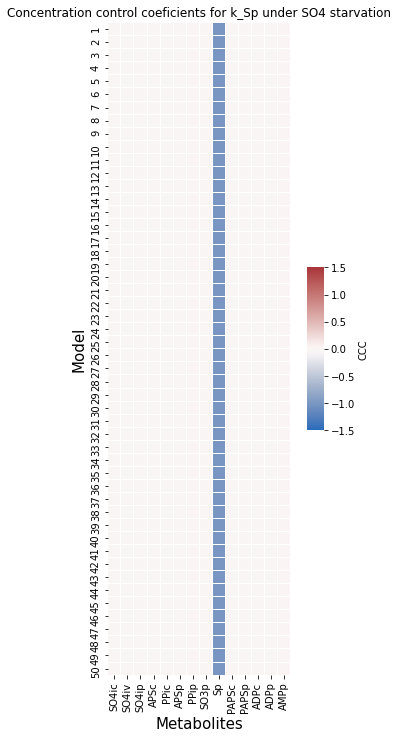

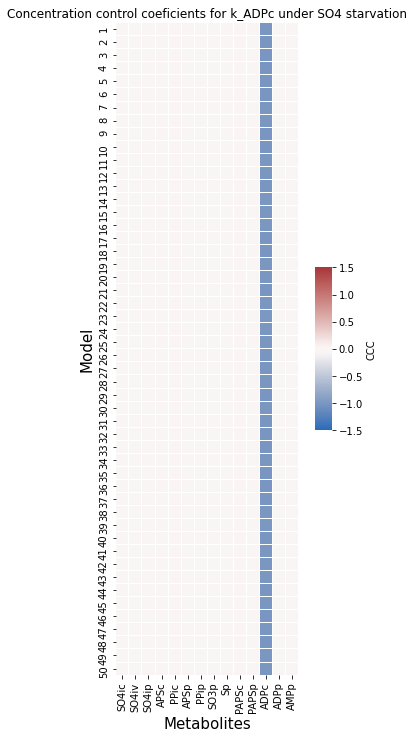

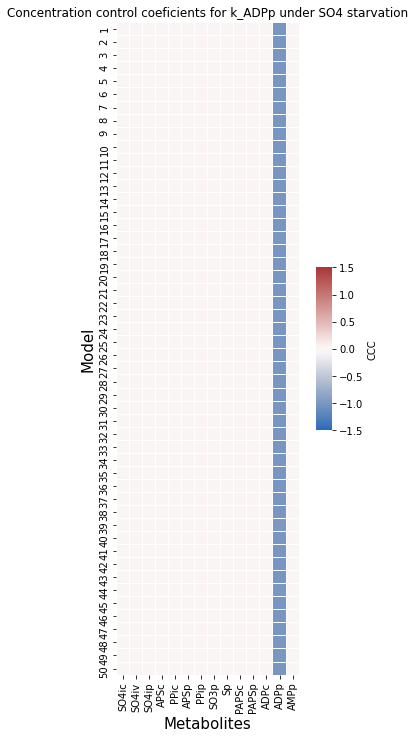

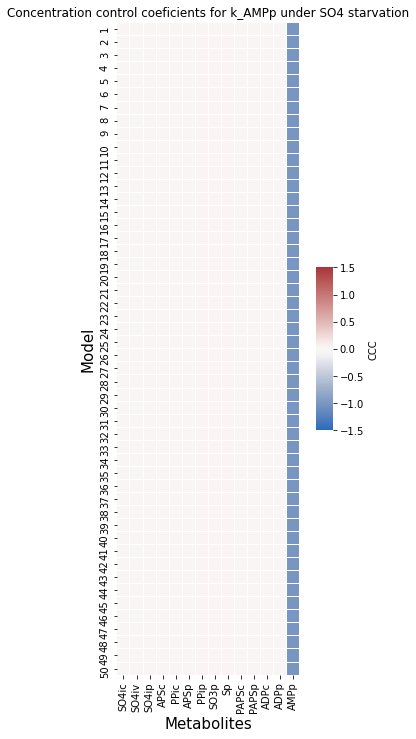

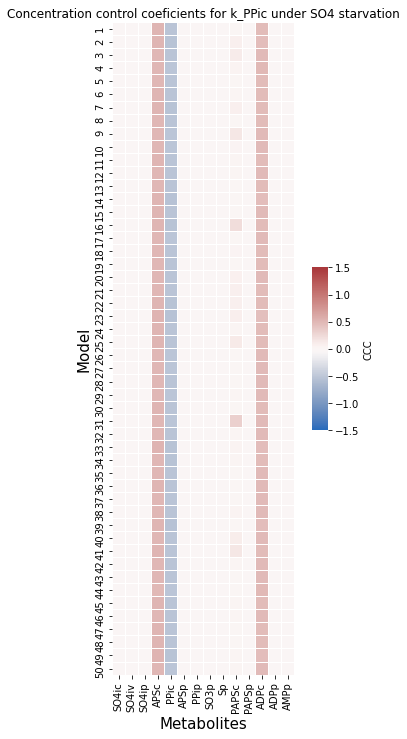

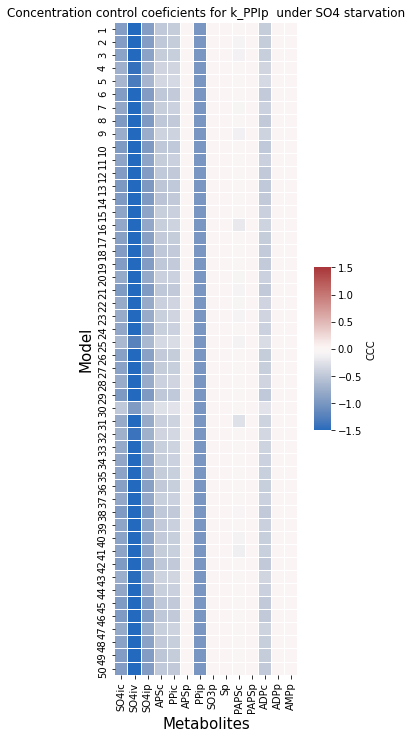

In [18]:
"""Visualise concentration control coefficients for individual reactions under SO4 starvation"""
Conc_coef_so4_starve = np.log(SO4_starve_flux_outputs[0]/SO4_starve_output_true[0])/np.log(1.2)

for i in range(len(Ordered_reactions)):
    df = pd.DataFrame(Conc_coef_so4_starve[i], index=np.arange(1,51), columns=Ordered_states)
    fig,ax = plt.subplots(figsize=(6,12))
    sns.heatmap(ax=ax, data=df, center=0, cmap="vlag", linewidths=0.005, square=True,vmin=-1.5, vmax=1.5, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'CCC'})
    ax.set_xlabel('Metabolites', fontsize=15)
    ax.set_ylabel('Model', fontsize=15)
    ax.set_title('Concentration control coeficients for {} under SO4 starvation'.format(Ordered_reactions[i]), fontsize=12)

Concentration control at ATP starvation

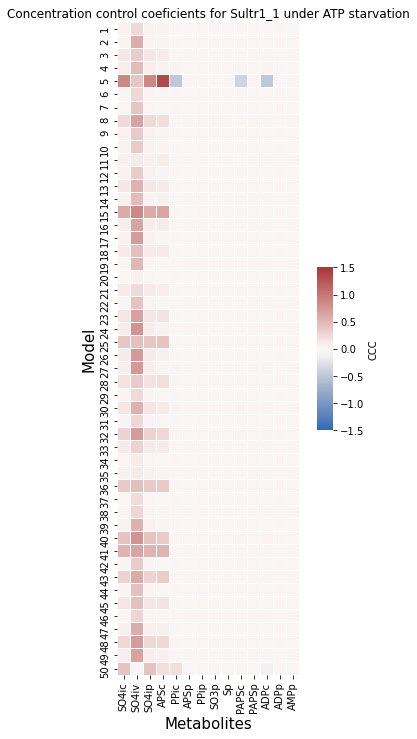

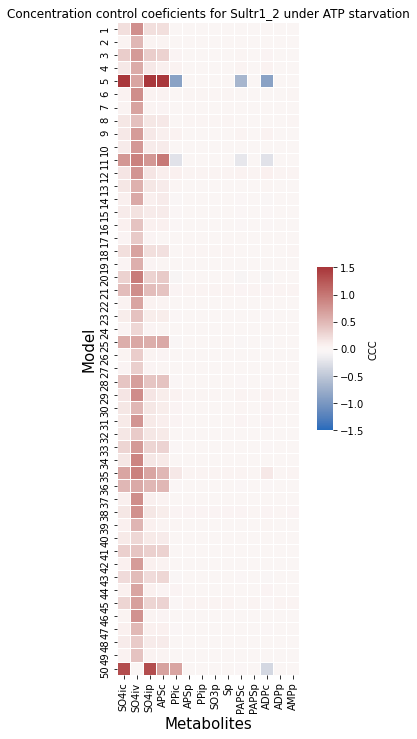

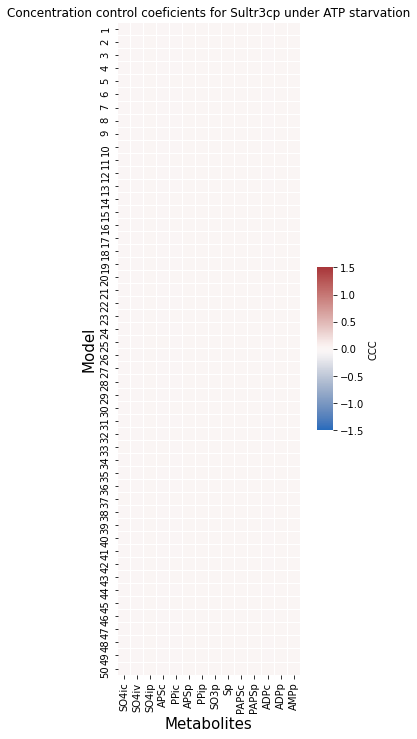

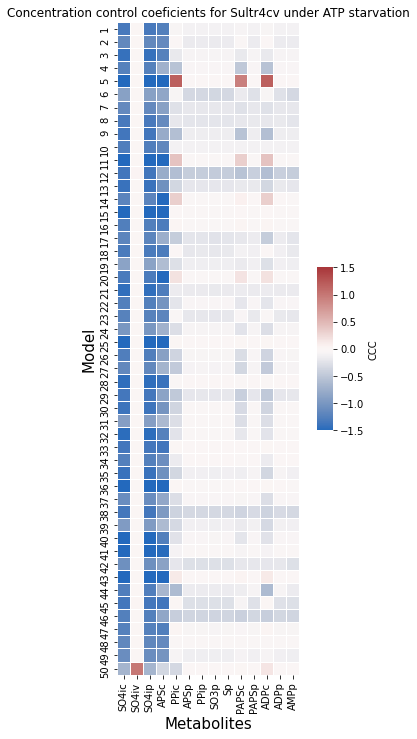

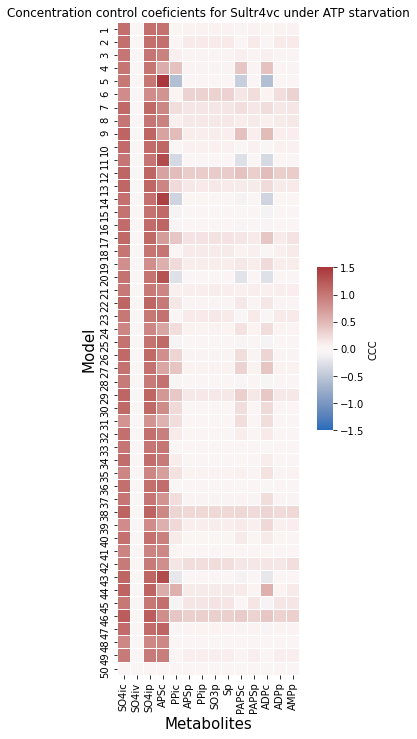

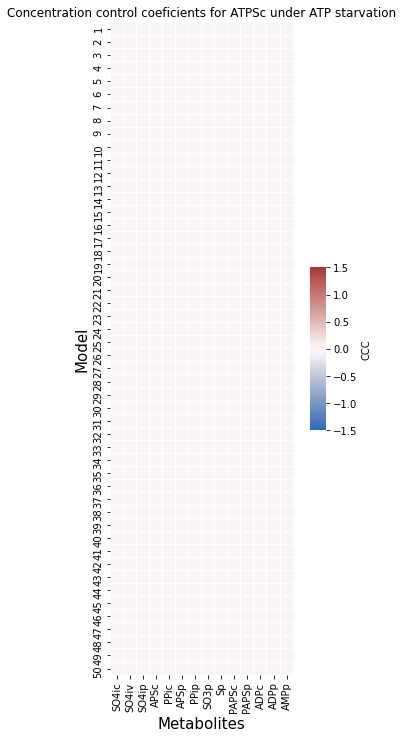

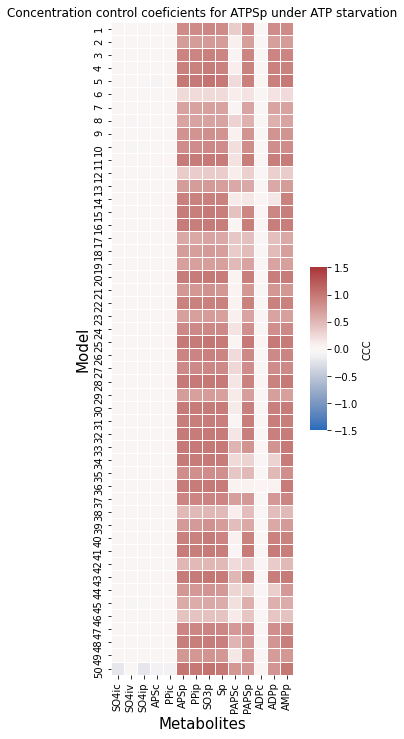

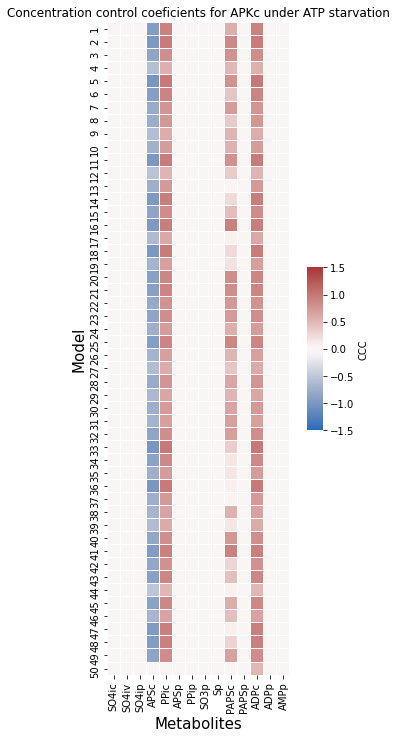

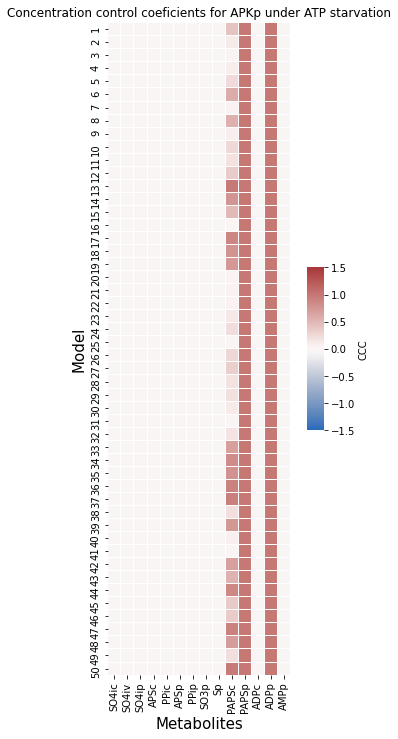

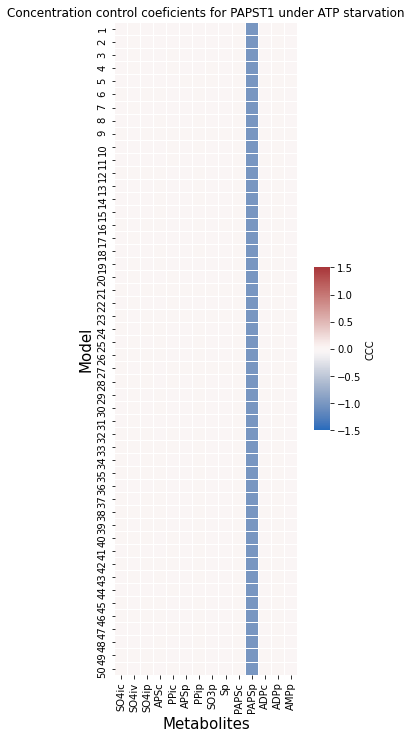

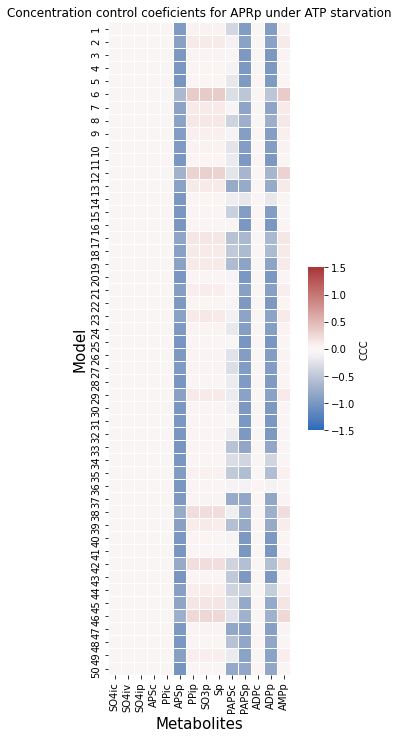

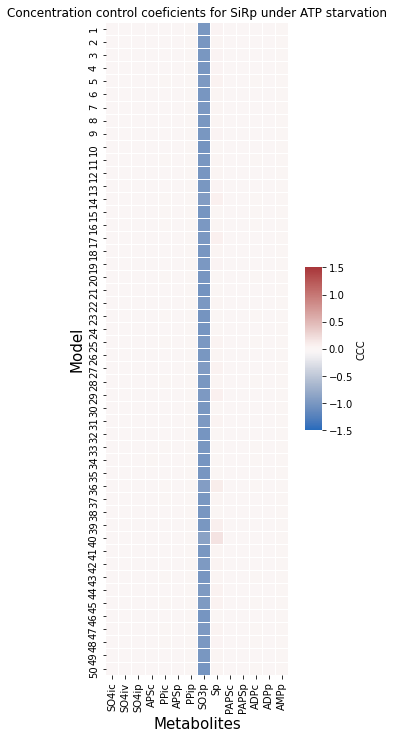

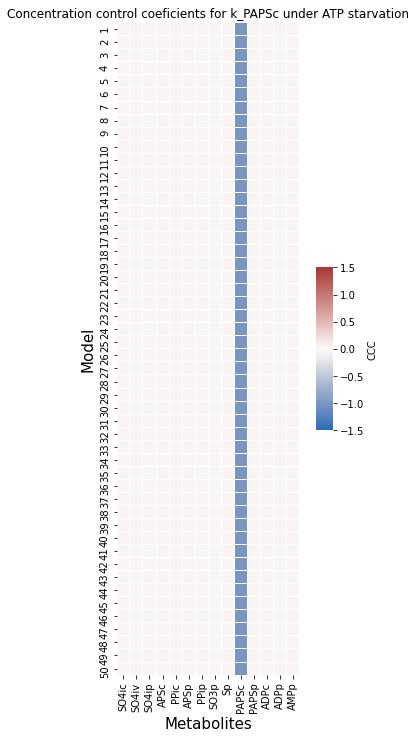

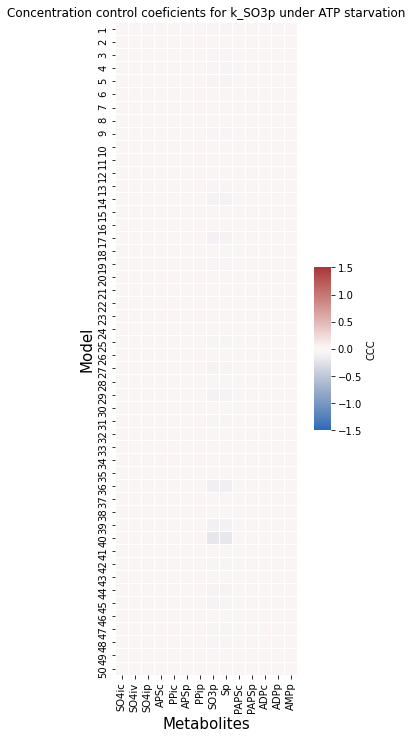

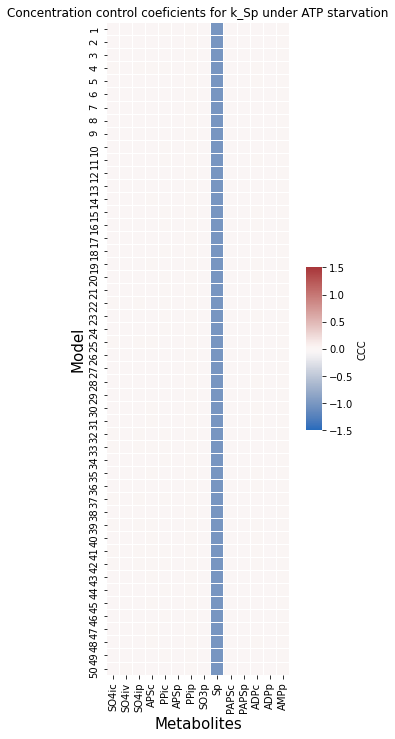

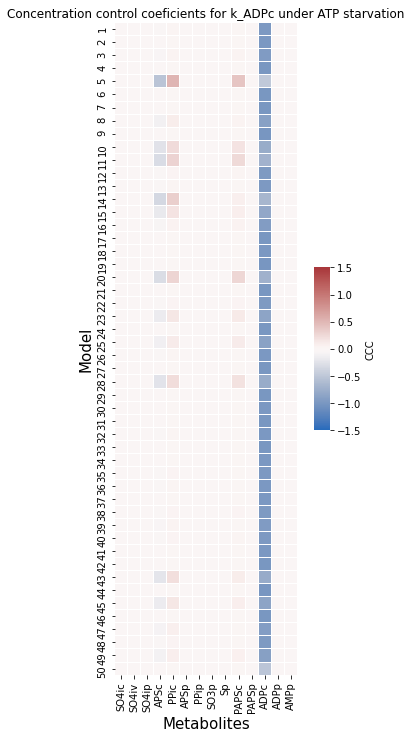

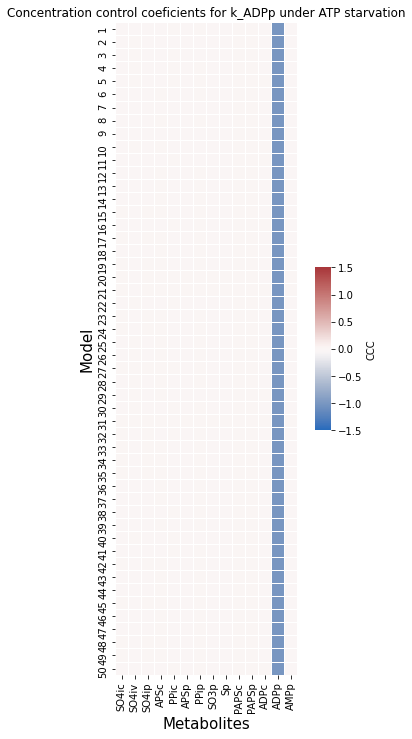

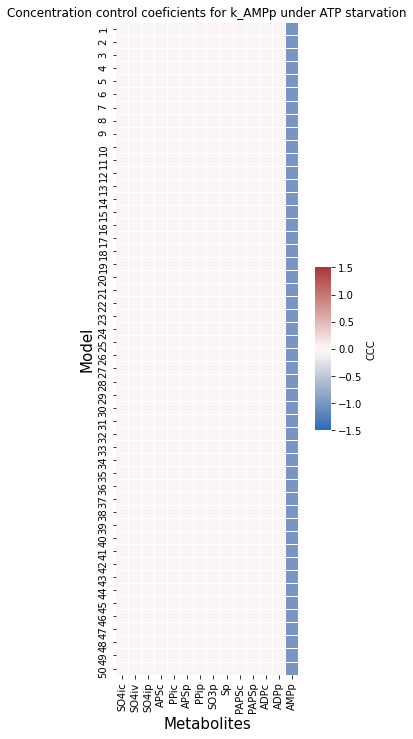

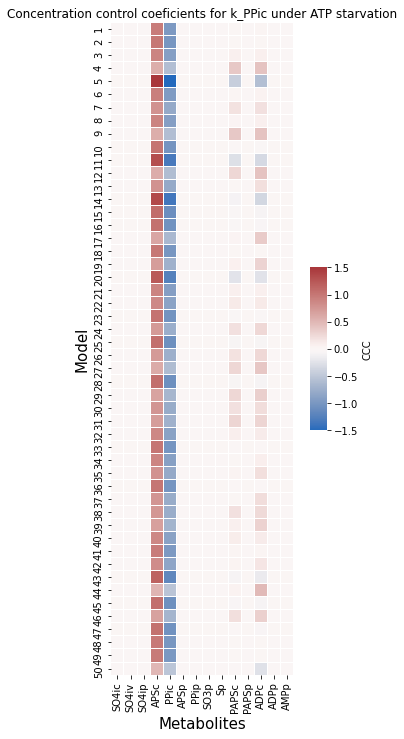

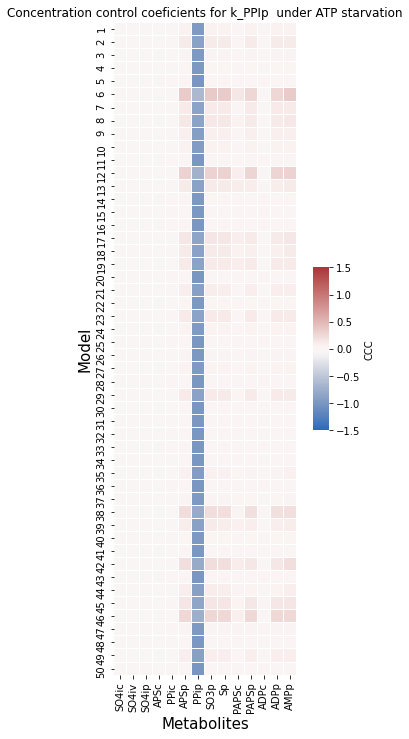

In [19]:
"""Visualise concentration control coefficients for individual reactions under ATP starvation"""
Conc_coef_atp_starve = np.log(ATP_starve_flux_outputs[0]/ATP_starve_output_true[0])/np.log(1.2)

for i in range(len(Ordered_reactions)):
    df = pd.DataFrame(Conc_coef_atp_starve[i], index=np.arange(1,51), columns=Ordered_states)
    fig,ax = plt.subplots(figsize=(6,12))
    sns.heatmap(ax=ax, data=df, center=0, cmap="vlag", linewidths=0.005, square=True,vmin=-1.5, vmax=1.5, cbar_kws={'shrink':0.25, 'aspect':10, 'label':'CCC'})
    ax.set_xlabel('Metabolites', fontsize=15)
    ax.set_ylabel('Model', fontsize=15)
    ax.set_title('Concentration control coeficients for {} under ATP starvation'.format(Ordered_reactions[i]), fontsize=12)

## Miscellaneous 

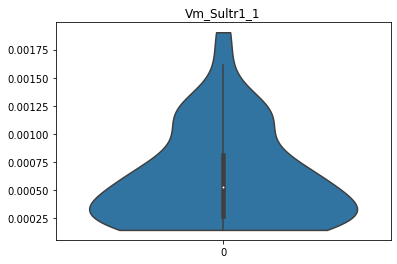

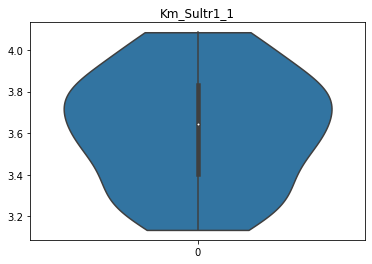

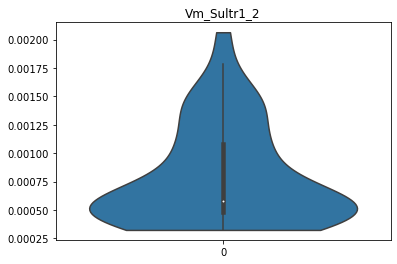

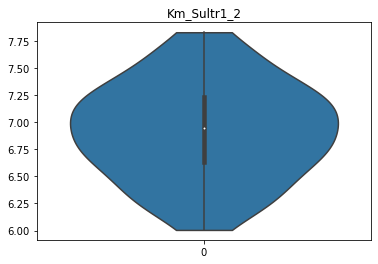

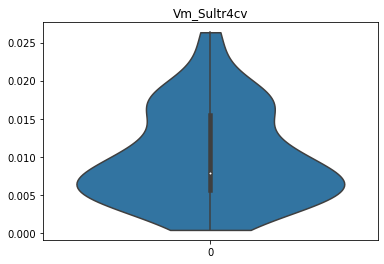

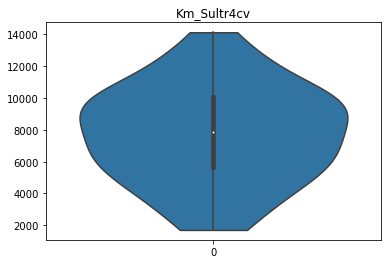

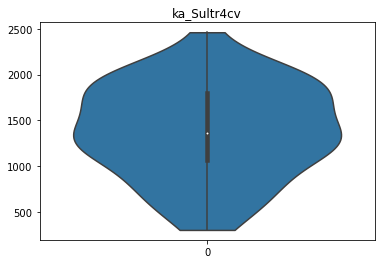

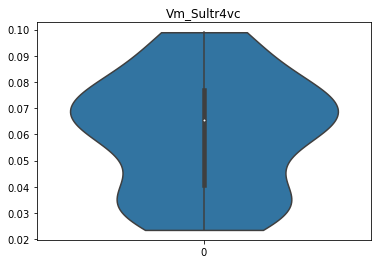

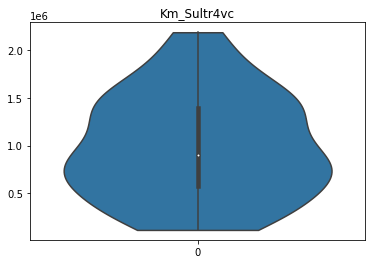

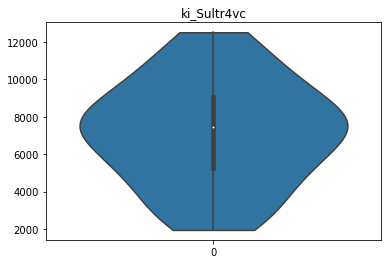

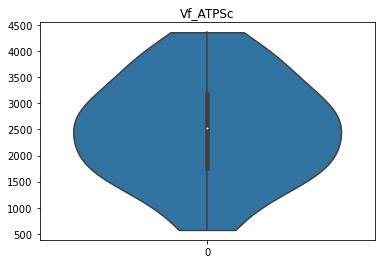

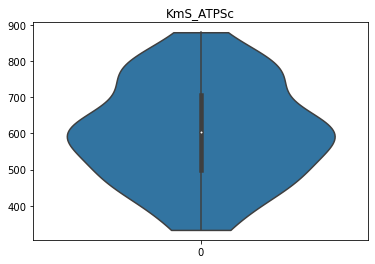

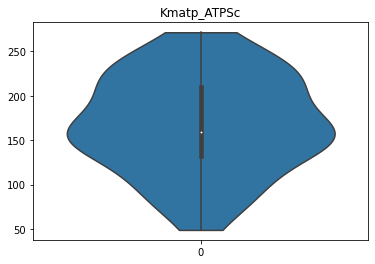

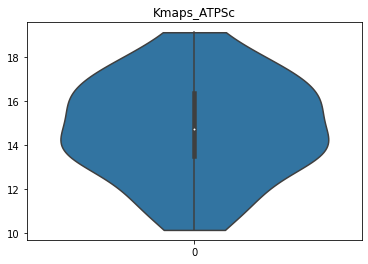

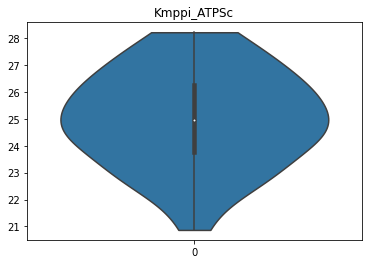

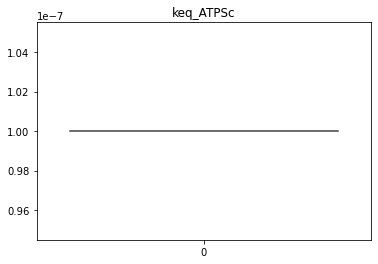

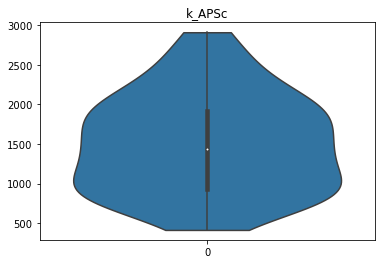

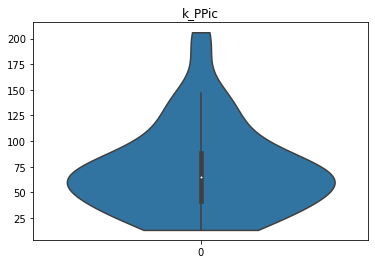

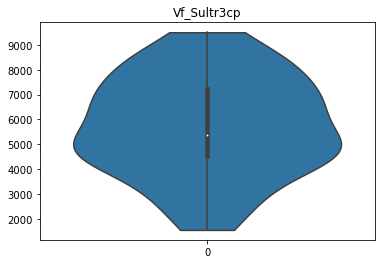

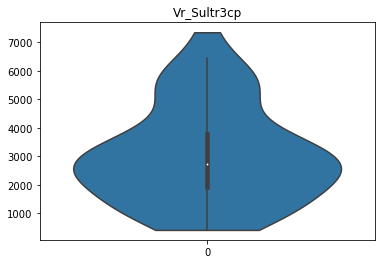

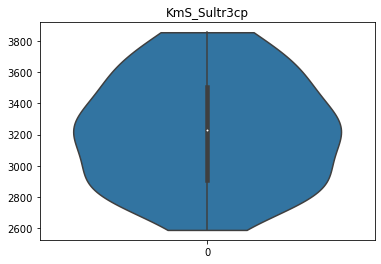

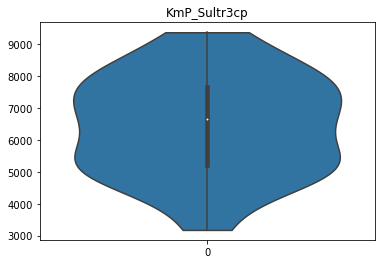

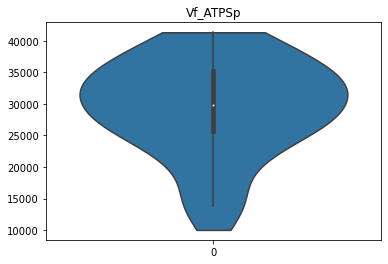

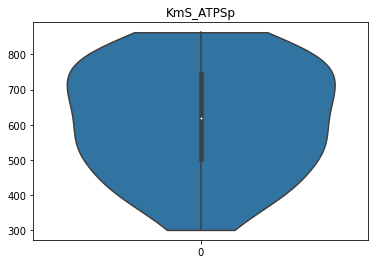

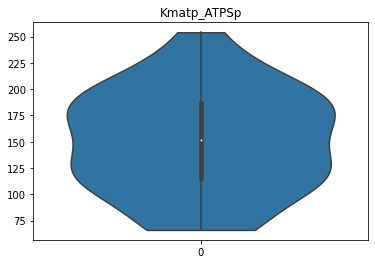

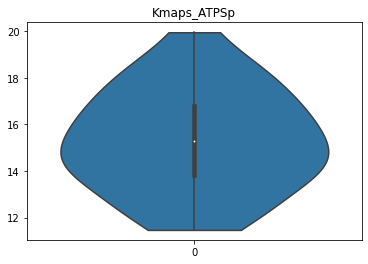

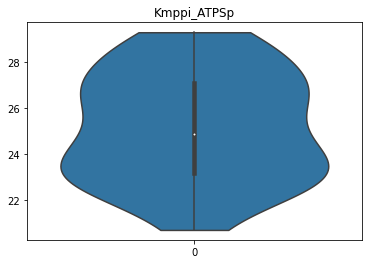

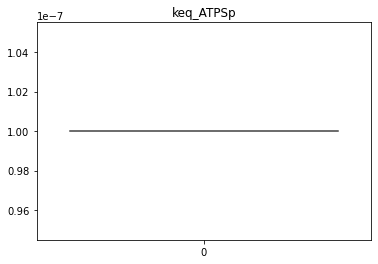

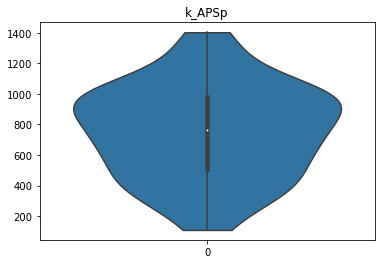

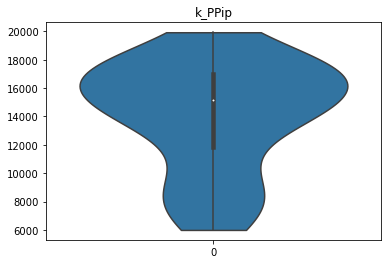

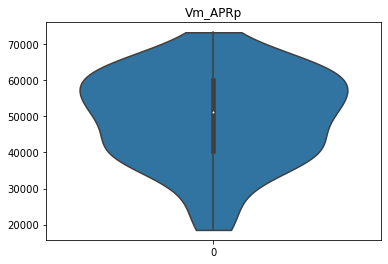

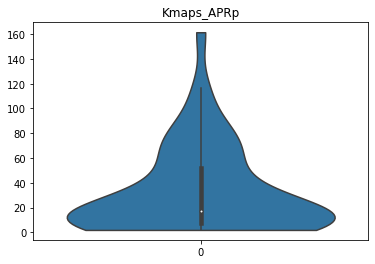

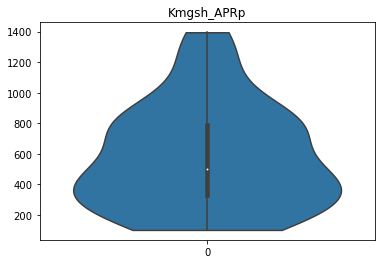

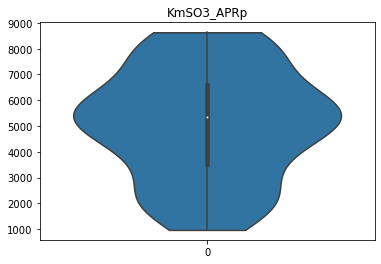

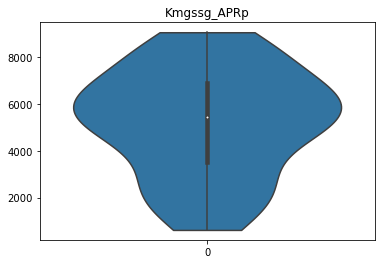

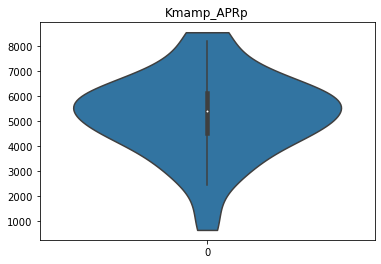

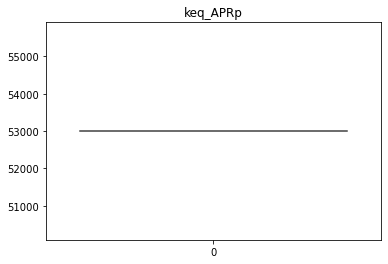

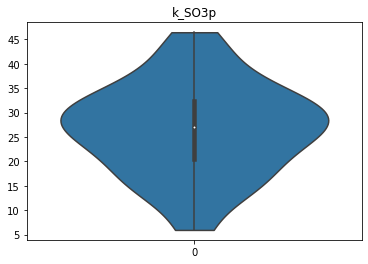

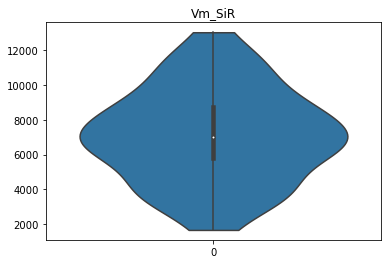

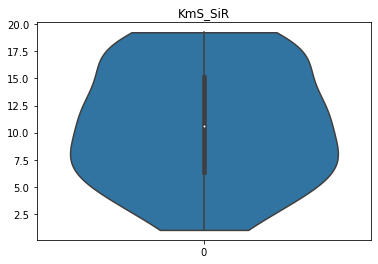

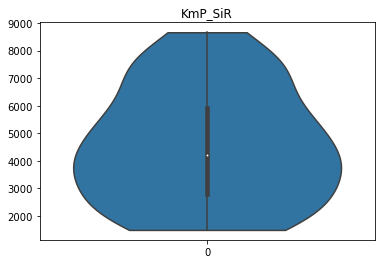

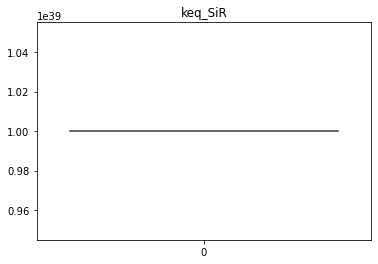

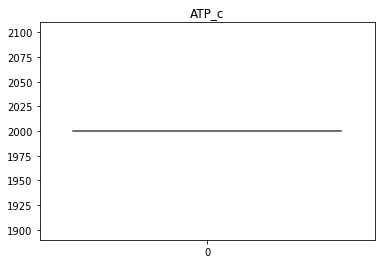

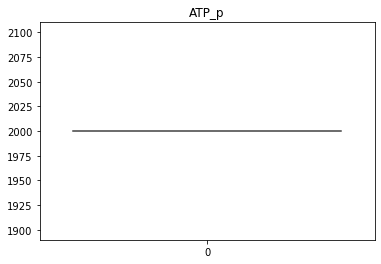

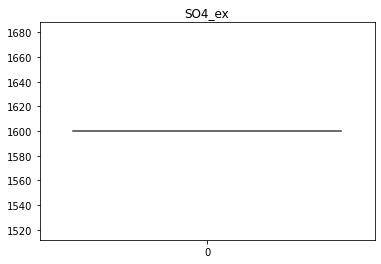

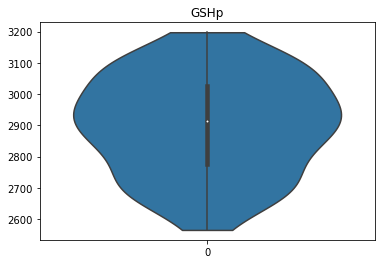

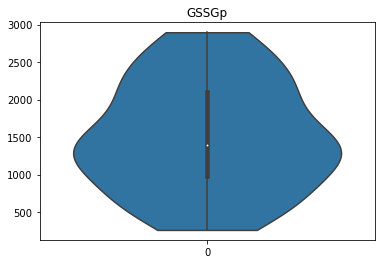

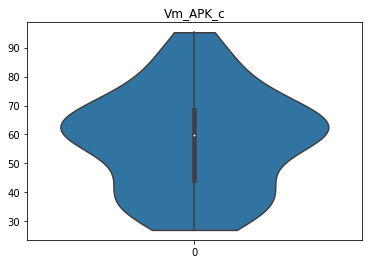

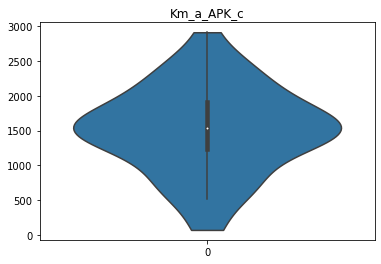

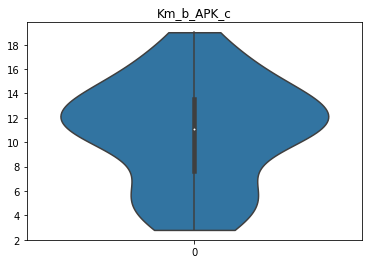

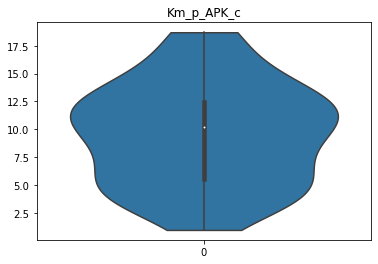

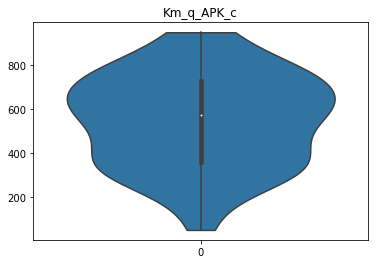

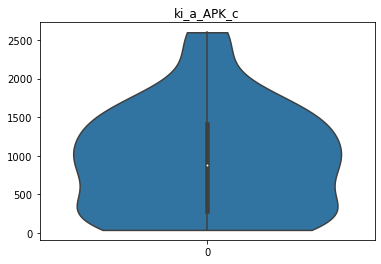

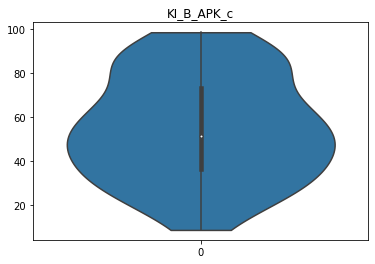

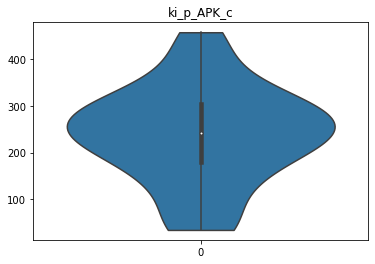

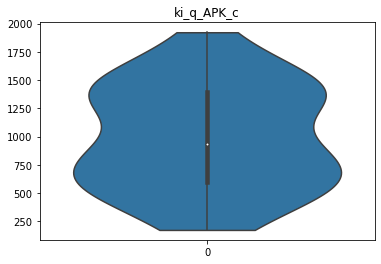

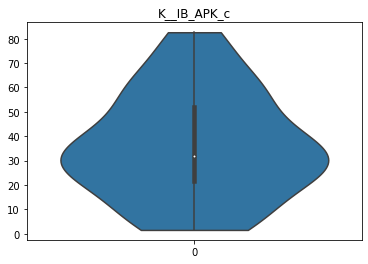

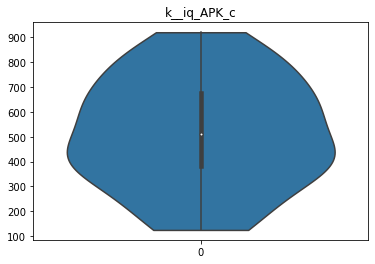

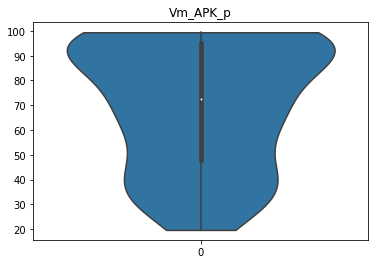

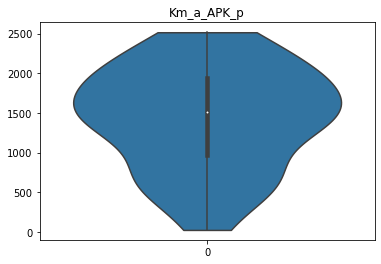

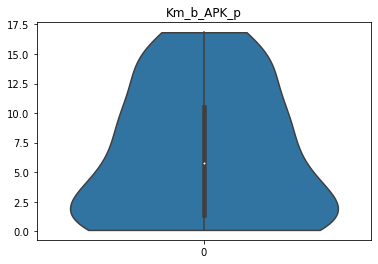

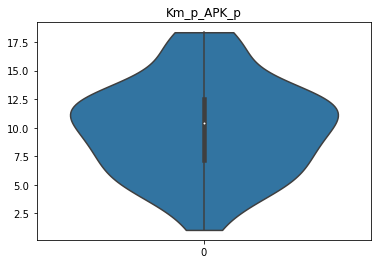

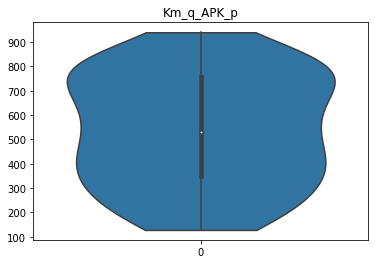

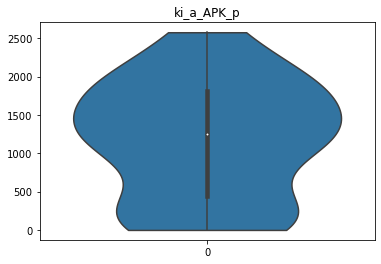

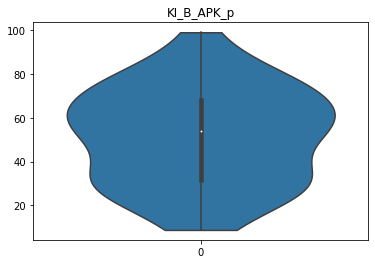

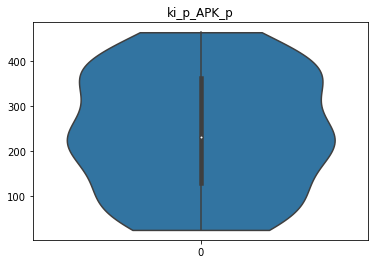

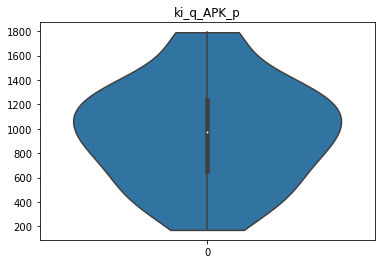

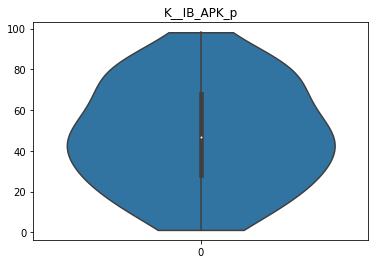

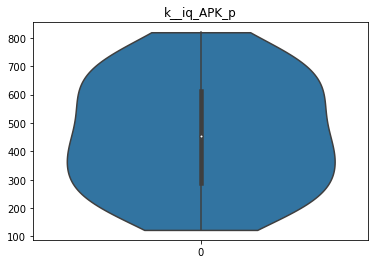

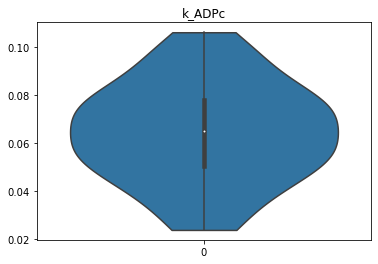

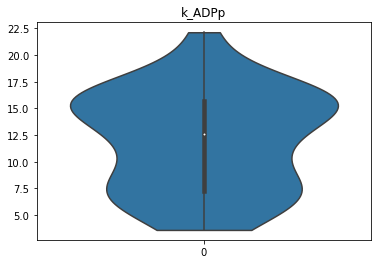

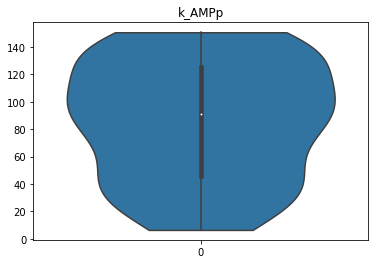

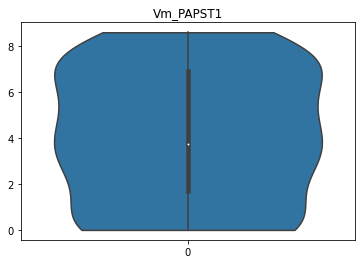

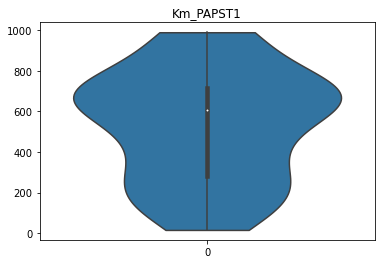

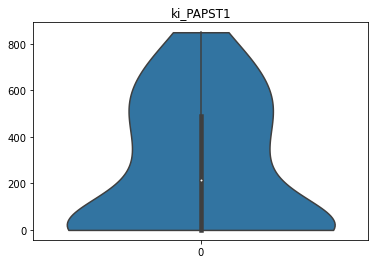

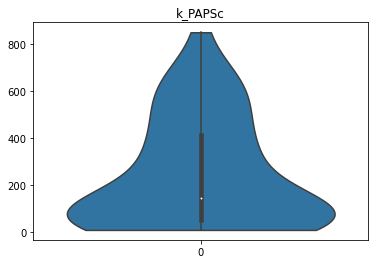

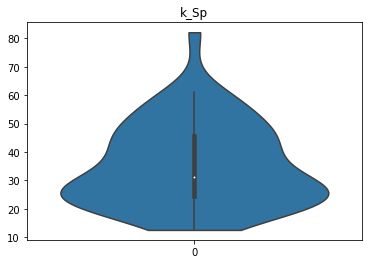

In [20]:
#Show distribution of fitted parameters across the ensemble
for i in range (77):
    sns.violinplot(data=All_params[:,i], cut=0)
    plt.title(Ordered_params[i])
    plt.show()

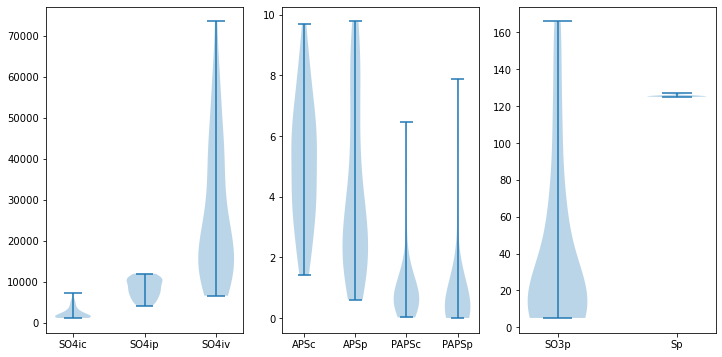

In [21]:
#Show distribtuion of steady-states of the ensemble
df = pd.DataFrame(True_output, index=np.arange(1,51), columns=Ordered_states)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
ax1.violinplot(dataset=[df['SO4ic'], df['SO4ip'], df['SO4iv']])
ax1.set(xticks=np.arange(1,4),xticklabels=['SO4ic', 'SO4ip', 'SO4iv'])
ax2.violinplot(dataset=[df['APSc'], df['APSp'], df['PAPSc'], df['PAPSp']])
ax2.set(xticks=np.arange(1,5), xticklabels=['APSc', 'APSp', 'PAPSc', 'PAPSp'])
ax3.violinplot(dataset=[df['SO3p'], df['Sp']])
ax3.set(xticks=np.arange(1,3), xticklabels=['SO3p', 'Sp'])
plt.show()

In [22]:
"""Plots the simulation. Time needs to be taken from solve_ivp, same for data, labels are in Ordered_states"""
def Draw_plot (time, data, labels):

    fig, ([(ax1, ax2), (ax3, ax4)]) = plt.subplots(2,2)
    fig.set_figwidth(15)
    fig.set_figheight(15)

    ax1.plot(time, data[0], label=labels[0], color = 'blue')
    ax1.plot(time, data[2], label=labels[2], color = 'green')
    ax1.plot(time, data[1], label=labels[1], color = 'orange')
    ax1.set_title('SO4 levels')
    ax1.set_ylabel('uM')
    ax1.set_xlabel('s')
    ax1.set_yscale('log')
    ax1.legend()

    ax2.plot(time, data[3], label=labels[3], color='blue')
    ax2.plot(time, data[5], label=labels[5], color='green')
    ax2.plot(time, data[9], label=labels[9], color='blue', linestyle='dashed')
    ax2.plot(time, data[10], label=labels[10], color='green', linestyle='dashed')
    ax2.set_title('APS/PAPS levels')
    ax2.set_ylabel('uM')
    ax2.set_xlabel('s')
    ax2.set_yscale('log')
    ax2.legend()

    ax3.plot(time, data[7], label=labels[7])
    ax3.plot(time, data[8], label=labels[8])
    ax3.set_title('SO3/S levels')
    ax3.set_ylabel('uM')
    ax3.set_xlabel('s')
    ax3.set_yscale('log')
    ax3.legend()

    ax4.plot(time, data[4], label=labels[4], color='blue')
    ax4.plot(time, data[6], label=labels[6], color='green')
    ax4.plot(time, data[11], label=labels[11], color='blue', linestyle='dashed')
    ax4.plot(time, data[12], label=labels[12], color='green', linestyle='dashed')
    ax4.plot(time, data[13], label=labels[13], color='green', linestyle='dotted')
    ax4.set_title('Nucleotide levels')
    ax4.set_ylabel('uM')
    ax4.set_xlabel('s')
    ax4.set_yscale('log')
    ax4.legend()